In [1]:
using Distributed # For multiprocessing
if nprocs() < 8 # If not started with multiple processes, we add some
    addprocs(8-nprocs(); enable_threaded_blas=false)
end;

In [2]:
import CSV
import TypedTables: Table, columnnames
import Printf: @sprintf, @printf # For converting numbers to strings
import LinearAlgebra: BLAS
# The BFGS optimizations use BLAS operations, but they are individually small so it's actually more efficient to run BLAS single-threaded.
BLAS.set_num_threads(1)

Load the isochrone table using `CSV.read` into a `TypedTables.Table` structure. This contains an isochrone table from PARSEC that has 26 steps in [M/H] and 71 steps in `logAge=log10(age [yr])` for a total of 1846 unique isochrones. For this example, this isochrone table actually has more steps in `logAge` than we want to use, so we will only use a subset of the available isochrones. In particular, the spacing of `ΔlogAge=0.05` dex results in the most recent time bins (`logAge < 8`) having too little stellar mass to measure robustly.

In [3]:
table = CSV.read("../../../../Work/Resources/isochrones/parsec/jwst/nircam_nov22/table.dat", Table; comment="#", delim=' ', ignorerepeated=true, 
    header=["Zini", "MH", "logAge", "Mini", "int_IMF", "Mass", "logL", "logTe", "logg", "label", "McoreTP", "C_O", "period0", "period1", "period2", 
        "period3", "period4", "pmode", "Mloss", "tau1m", "X",  "Y", "Xc",  "Xn",  "Xo",  "Cexcess",  "Z", "mbolmag",  "F070W",  "F090W",  "F115W",  
        "F150W",  "F200W",  "F277W",  "F356W",  "F444W",  "F150W2",  "F322W2",  "F140M",  "F162M",  "F182M",  "F210M",  "F250M",  "F300M",  "F335M",  
        "F360M",  "F410M",  "F430M",  "F460M",  "F480M"])

Table with 50 columns and 709192 rows:
      Zini       MH        logAge  Mini      int_IMF  Mass   logL    logTe   ⋯
    ┌─────────────────────────────────────────────────────────────────────────
 1  │ 2.4652e-5  -2.19174  6.6     0.1       1.17111  0.1    -1.436  3.5769  ⋯
 2  │ 2.4652e-5  -2.19174  6.6     0.105145  1.2127   0.105  -1.411  3.5791  ⋯
 3  │ 2.4652e-5  -2.19174  6.6     0.109821  1.24828  0.109  -1.387  3.5809  ⋯
 4  │ 2.4652e-5  -2.19174  6.6     0.124     1.34512  0.124  -1.321  3.5865  ⋯
 5  │ 2.4652e-5  -2.19174  6.6     0.129464  1.37867  0.129  -1.298  3.5885  ⋯
 6  │ 2.4652e-5  -2.19174  6.6     0.140418  1.4407   0.14   -1.252  3.5923  ⋯
 7  │ 2.4652e-5  -2.19174  6.6     0.149107  1.4856   0.149  -1.219  3.595   ⋯
 8  │ 2.4652e-5  -2.19174  6.6     0.183261  1.63379  0.182  -1.1    3.6048  ⋯
 9  │ 2.4652e-5  -2.19174  6.6     0.197245  1.68445  0.196  -1.057  3.6085  ⋯
 10 │ 2.4652e-5  -2.19174  6.6     0.207292  1.71805  0.206  -1.029  3.6111  ⋯
 11 │ 2.4652e

Check the available columns in the table

In [4]:
columnnames(table)

(:Zini, :MH, :logAge, :Mini, :int_IMF, :Mass, :logL, :logTe, :logg, :label, :McoreTP, :C_O, :period0, :period1, :period2, :period3, :period4, :pmode, :Mloss, :tau1m, :X, :Y, :Xc, :Xn, :Xo, :Cexcess, :Z, :mbolmag, :F070W, :F090W, :F115W, :F150W, :F200W, :F277W, :F356W, :F444W, :F150W2, :F322W2, :F140M, :F162M, :F182M, :F210M, :F250M, :F300M, :F335M, :F360M, :F410M, :F430M, :F460M, :F480M)

In [5]:
unique(table.logAge) # These are `log10(age)`, where the age is in years.

71-element Vector{Float64}:
  6.6
  6.65
  6.7
  6.75
  6.8
  6.85
  6.9
  6.95
  7.0
  7.05
  7.1
  7.15
  7.2
  ⋮
  9.55001
  9.60001
  9.65001
  9.70001
  9.75001
  9.80001
  9.85001
  9.90001
  9.95001
 10.00001
 10.05001
 10.10001

For the most metal-poor PARSEC isochrones (e.g., -2.2 [M/H]), there are multiple individual isochrones with the same [M/H] but different `Zini`. This can be seen as `length(unique(table.Zini)) > length(unique(table.MH))` below.

In [6]:
unique(table.MH) # These are metallicities, [M/H]

26-element Vector{Float64}:
 -2.19174
 -2.1
 -2.0
 -1.9
 -1.8
 -1.7
 -1.6
 -1.5
 -1.4
 -1.3
 -1.2
 -1.1
 -1.0
 -0.9
 -0.8
 -0.7
 -0.6
 -0.5
 -0.4
 -0.3
 -0.2
 -0.1
  0.0
  0.1
  0.2
  0.3

In [7]:
unique(table.Zini)

29-element Vector{Float64}:
 2.4652e-5
 3.1035e-5
 3.9069e-5
 4.9184e-5
 0.00012351
 0.00015547
 0.0001957
 0.00024632
 0.00031003
 0.00039019
 0.00049103
 0.00061788
 0.00077741
 ⋮
 0.0024432
 0.0030686
 0.0038518
 0.0048313
 0.0060543
 0.0075779
 0.0094713
 0.011816
 0.01471
 0.018261
 0.022594
 0.027842

For bookkeeping purposes, it is simplest for each isochrone to be identifiable by a unique [M/H], so we we will use the `Zini` values to calculate new [M/H] values. These are now *initial* metallicities. 

In [8]:
import StarFormationHistories: MH_from_Z
# Rewrite [M/H] column. 
for i in eachindex(table)
    table.MH[i] = MH_from_Z(table.Zini[i], 0.01471)
end
unique(table.MH)

29-element Vector{Float64}:
 -2.8000208992140845
 -2.7000110527475605
 -2.6000175983197713
 -2.500009794651941
 -2.100012070548602
 -2.0000162211614816
 -1.9000073196768041
 -1.8000170782347087
 -1.7000105737090876
 -1.600009209339709
 -1.5000150464034467
 -1.4000147226611754
 -1.3000117782255178
  ⋮
 -0.8000106239270766
 -0.7000142637673
 -0.6000162328319801
 -0.5000166309399301
 -0.40001148522876806
 -0.3000154566956319
 -0.20001378845202142
 -0.10003154653740932
 -4.821637332766436e-17
  0.09998742559427602
  0.19998649952690642
  0.299992911269662

## Observational Model 

We'll construct a model Hess diagram from the populations in this isochrone table. First we need to set up our observational models for photometric error and incompleteness. You would typically measure these from artificial star tests but we'll make up some models here using functions built into StarFormationHistories.jl.

In [9]:
import StarFormationHistories: Martin2016_complete, exp_photerr

In [10]:
distmod = 25.0 # Distance modulus 
@everywhere F090W_complete(m) = Martin2016_complete(m,1.0,28.5,0.7)
@everywhere F150W_complete(m) = Martin2016_complete(m,1.0,27.5,0.7)
@everywhere F090W_error(m) = min( exp_photerr(m, 1.03, 15.0, 36.0, 0.02), 0.4 )
@everywhere F150W_error(m) = min( exp_photerr(m, 1.03, 15.0, 35.0, 0.02), 0.4 );

We'll make a few plots showing the adopted models. Below we set up PyPlot.jl (a wrapper for Python's matplotlib package).

In [11]:
import PyPlot as plt
import PyPlot: @L_str # For LatexStrings
import PyCall: @pyimport
plt.rc("text", usetex=true)
plt.rc("text.latex", preamble="\\usepackage{amsmath}") # for \text
plt.rc("font", family="serif", serif=["Computer Modern"], size=14)
plt.rc("figure", figsize=(5,5))
plt.rc("patch", linewidth=1, edgecolor="k", force_edgecolor=true)
# https://matplotlib.org/stable/gallery/images_contours_and_fields/interpolation_methods.html
plt.rc("image", interpolation="none")

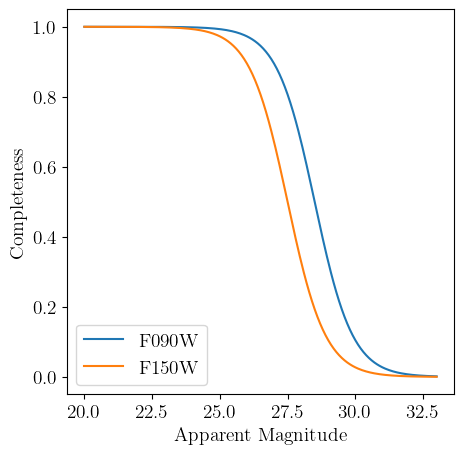

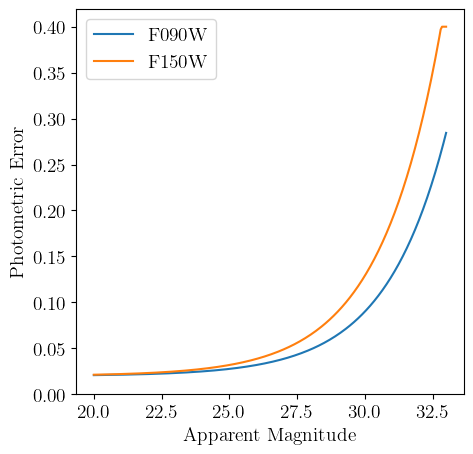

(0.0, 0.41895850114873723)

In [12]:
plotmags=20.0:0.05:33.0

fig,ax1=plt.subplots()
ax1.plot(plotmags,F090W_complete.(plotmags),label="F090W")
ax1.plot(plotmags,F150W_complete.(plotmags),label="F150W")
ax1.set_xlabel("Apparent Magnitude")
ax1.set_ylabel("Completeness")
ax1.legend(loc="lower left")

plotmags=20.0:0.05:33.0
fig,ax1=plt.subplots()
ax1.plot(plotmags,F090W_error.(plotmags),label="F090W")
ax1.plot(plotmags,F150W_error.(plotmags),label="F150W")
ax1.set_xlabel("Apparent Magnitude")
ax1.set_ylabel("Photometric Error")
ax1.legend(loc="upper left")
ax1.set_ylim([0.0,ax1.get_ylim()[2]])

We put a maximum on the magnitude error in the model because most of the time one would place a cut on the photometric catalog in either signal to noise (e.g., SNR>5) or magnitude error (e.g., error < 0.4). From a practical perspective, if we allow the photometric error model to grow too large, it will hurt the efficiency of `partial_cmd_smooth` for template creation later.

## Template Construction

We may now define our mock star formation history. We will use `partial_cmd_smooth` to construct the templates for a Hess diagram model with F150W on the y-axis and F090W-F150W on the x-axis, with an initial mass function model from InitialMassFunctions.jl. We'll construct all 1846 templates, one for every isochrone in our table, but this may not always be necessary.

In [13]:
# 
@everywhere import StarFormationHistories: partial_cmd_smooth, NoBinaries, RandomBinaryPairs
@everywhere import InitialMassFunctions: Kroupa2001

In [14]:
# Some additional setup
edges = (range(-0.65, 1.75, length=100), range(distmod-7.0, distmod+3.0, length=100)) # The bin edges for the Hess diagrams (17,28)
imf = Kroupa2001(0.08, 100.0) # Initial mass function model
binary_model = RandomBinaryPairs(0.3) 
unique_logAge = unique(table.logAge)
unique_MH = unique(table.MH)
template_norm = 1e3 # The stellar mass of the populations in each template

# Now define the subset of unique logAges for which isochrones are available
# that we actually want to use for our example.
# As stated above, the isochrone file we read in has a uniform grid spacing of 
# `ΔlogAge=0.05`. We will only use a spacing of 0.1 dex for logAge < 9 if isochrone_cut is true.
isochrone_cut::Bool = false
if isochrone_cut
    logAge_cutval = 9
    selection = vcat( findall( <=(logAge_cutval), unique_logAge)[begin:2:end],
                      findall( >(logAge_cutval), unique_logAge) )
    unique_logAge = unique_logAge[selection]
end

In [15]:
@printf("Number of final isochrones is: %i",length(unique_logAge) * length(unique_MH))

Number of final isochrones is: 2059

In [16]:
# # Constructing the templates; single-threaded with push!
# templates = Vector{Matrix{Float64}}(undef,0)
# template_logAge = Vector{Float64}(undef,0)
# template_MH = Vector{Float64}(undef,0)
# # We don't strictly need to save the initial masses (m_ini) or the isochrone magnitudes (iso_mags), 
# # but we'll use them later in this example so we'll save them now. 
# template_mini = Vector{Vector{Float64}}(undef,0)
# template_isomags = Vector{Vector{Vector{Float64}}}(undef,0)
# for logage in unique_logAge 
#     for mh in unique_MH
#         # Combination of a logage and an MH defines a unique isochrone.
#         # Pick out all entries in `table` that match this combination; these will be row indices
#         # into the table of the stars in this specific isochrone.
#         local good = findall( (table.MH .== mh) .& (table.logAge .== logage) )
#         # Chop off the last entry in the isochrone because its the 30 mag weird thing that parsec does.
#         local m_ini = table.Mini[good][begin:end-1] # These are the initial masses of the stars in the isochrone, in solar masses.
#         push!(template_mini, m_ini)
#         local iso_mags = [table.F090W[good][begin:end-1], table.F150W[good][begin:end-1]] # These are the absolute magnitudes we want from the isochrone.
#         push!(template_isomags, iso_mags)
#         # Create template and push
#         push!(templates, partial_cmd_smooth( m_ini, iso_mags, [F090W_error, F150W_error], 2, [1,2], imf, [F090W_complete, F150W_complete]; 
#                 dmod=distmod, normalize_value=template_norm, edges=edges).weights )
#         push!(template_logAge, logage)
#         push!(template_MH, mh)
#     end
# end

In [17]:
# Constructing the templates; multi-threaded with pre-allocated arrays
templates = Vector{Matrix{Float64}}(undef, length(unique_logAge) * length(unique_MH))
template_logAge = Vector{Float64}(undef, length(templates))
template_MH = Vector{Float64}(undef, length(templates))
# We don't strictly need to save the initial masses (m_ini) or the isochrone magnitudes (iso_mags), 
# but we'll use them later in this example so we'll save them now. 
template_mini = Vector{Vector{Float64}}(undef, length(templates))
template_isomags = Vector{Vector{Vector{Float64}}}(undef, length(templates))
# Multi-threaded, nested loop iterating over unique_MH (outer loop) and unique_logAge (inner loop). 
# Using `enumerate` also gets us index `i` of iteration.
Base.Threads.@threads for (i, (mh, logage)) in collect(enumerate(Iterators.product(unique_MH, unique_logAge)))
    # Combination of a logage and an MH defines a unique isochrone.
    # Pick out all entries in `table` that match this combination; these will be row indices
    # into the table of the stars in this specific isochrone.
    local good = findall( (table.MH .== mh) .& (table.logAge .== logage) )
    # Chop off the last star because its the 30 mag weird thing that parsec does.
    local m_ini = table.Mini[good][begin:end-1] # These are the initial masses of the stars in the isochrone, in solar masses.
    template_mini[i] = m_ini
    local iso_mags = [table.F090W[good][begin:end-1], table.F150W[good][begin:end-1]] # These are the absolute magnitudes we want from the isochrone.
    template_isomags[i] = iso_mags
    # Create templates
    templates[i] = partial_cmd_smooth(m_ini, iso_mags, [F090W_error, F150W_error], 2, [1,2], imf, [F090W_complete, F150W_complete]; 
                                      dmod=distmod, normalize_value=template_norm, edges=edges, 
                                      binary_model=binary_model).weights
    template_logAge[i] = logage
    template_MH[i] = mh
end

In [18]:
# Write single isochrone to file
# Some extra info here https://discourse.julialang.org/t/formatting-float64-output-with-csv-write/23479
# let idx = length(unique_MH)*70 + findfirst(==(first(unique_MH)), unique_MH) # 1821
let idx = length(unique_MH)*(findmin( x -> abs(exp10(x-9) - 12.59), unique_logAge)[2] - 1) + findfirst(==(first(unique_MH)), unique_MH) # 1821
    logage = template_logAge[idx]
    mh = template_MH[idx]
    println(logage, " ", mh)
    # local good = findall((table.MH .== mh) .& (table.logAge .== logage))
    # open("isochrone.txt","w") do file
    #     print(file, "m_ini F090W F150W F277W\n")
    #     for i in good[begin:end-1]
    #         @printf(file, "%.10f %.3f %.3f %.3f\n", table.Mini[i], table.F090W[i], table.F150W[i], table.F277W[i])
    #     end
    # end
end

10.10001 -2.8000208992140845


In [19]:
# Sort the template_logAge and template_MH so we have a guarantee for later
permidx = sortperm(template_logAge)
template_logAge = template_logAge[permidx]
template_MH = template_MH[permidx]
templates = templates[permidx];

We'll plot a few templates for reference.

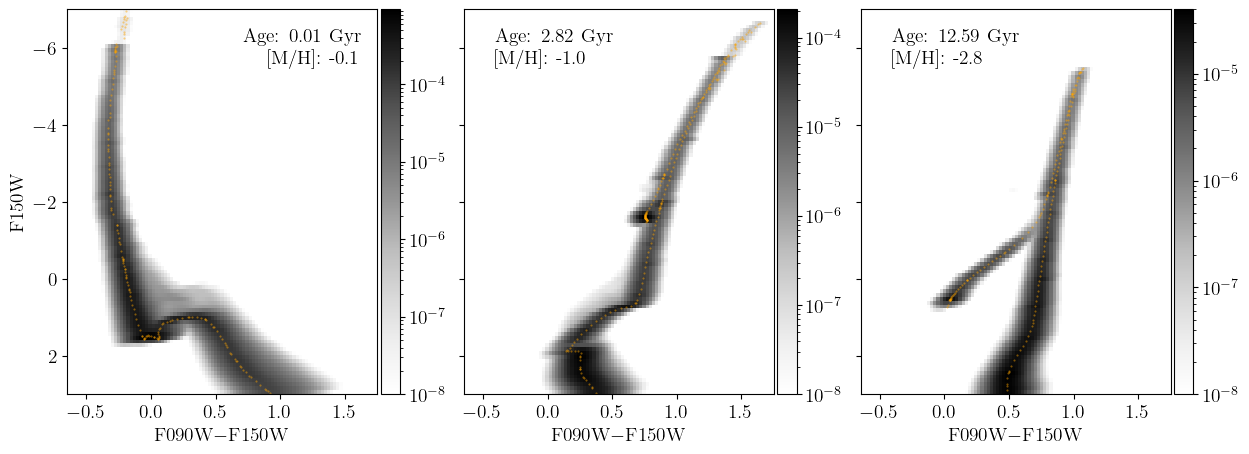

In [20]:
# When displaying the templates we will divide them by template_norm so that that units of the templates are
# [N / M_sun], or expected number of stars per bin per solar mass of stars formed.
# Plotting in absolute magnitude here rather than apparent on y-axis
# display_templates = (100,1495,1821) # Before option of using isochrone_cut
display_templates = ( length(unique_MH)*(findmin( x -> abs(x - 6.8), unique_logAge)[2] - 1) + 
                              findmin( x -> abs(x - (-0.1)), unique_MH)[2],
                     length(unique_MH)*(findmin( x -> abs(exp10(x-9) - 2.82), unique_logAge)[2] - 1) + 
                                        findmin( x -> abs(x - (-1.0)), unique_MH)[2],
                      length(unique_MH)*(findmin( x -> abs(exp10(x-9) - 12.59), unique_logAge)[2] - 1) + 
                                         findmin( x -> abs(x - (-2.8)), unique_MH)[2] )
                                         # findfirst(==(first(unique_MH)), unique_MH) )

fig,axs=plt.subplots(1,3,sharey=true,sharex=true,figsize=(15,5))
fig.subplots_adjust(hspace=0.0,wspace=0.075)

im1 = axs[1].imshow(permutedims(templates[display_templates[1]]) ./ template_norm, origin="lower", 
    extent=(extrema(edges[1])..., extrema(edges[2] .- distmod)...), 
    aspect="auto", cmap="Greys", norm=plt.matplotlib.colors.LogNorm(vmin=1e-8), rasterized=true) 
im2 = axs[2].imshow(permutedims(templates[display_templates[2]]) ./ template_norm, origin="lower", 
    extent=(extrema(edges[1])..., extrema(edges[2] .- distmod)...), 
    aspect="auto", cmap="Greys", norm=plt.matplotlib.colors.LogNorm(vmin=1e-8), rasterized=true) 
im3 = axs[3].imshow(permutedims(templates[display_templates[3]]) ./ template_norm, origin="lower", 
    extent=(extrema(edges[1])..., extrema(edges[2] .- distmod)...), 
    aspect="auto", cmap="Greys", norm=plt.matplotlib.colors.LogNorm(vmin=1e-8), rasterized=true) 
# im1.set_clim( [0.5, im1.get_clim()[2]] )
for ax in axs
    ax.set_xlabel(L"F090W$-$F150W")
end
axs[1].set_ylabel("F150W")
axs[1].set_ylim(reverse(extrema(edges[2])).-distmod) 
axs[1].set_xlim(extrema(edges[1]))
# Label the templates with their ages and metallicities
axs[1].text(0.95,0.95,(@sprintf "Age: %.2f Gyr \n [M/H]: %.1f" exp10(template_logAge[display_templates[1]])/1e9 template_MH[display_templates[1]]), transform=axs[1].transAxes,ha="right",va="top")
axs[2].text(0.1,0.95,(@sprintf "Age: %.2f Gyr \n [M/H]: %.1f" exp10(template_logAge[display_templates[2]])/1e9 template_MH[display_templates[2]]), transform=axs[2].transAxes,ha="left",va="top")
axs[3].text(0.1,0.95,(@sprintf "Age: %.2f Gyr \n [M/H]: %.1f" exp10(template_logAge[display_templates[3]])/1e9 template_MH[display_templates[3]]), transform=axs[3].transAxes,ha="left",va="top")
fig.colorbar(im1, ax=axs[1], pad=0.01)
fig.colorbar(im2, ax=axs[2], pad=0.01)
fig.colorbar(im3, ax=axs[3], pad=0.01)

# Optionally, plot photometric error bars along the left. Errors are small in this model so they don't show very well.
plot_errors::Bool = false
if plot_errors
    # Set up points to show the photometric errors
    error_points = minimum(edges[2])+1.0:0.5:maximum(edges[2])-0.5
    error_points_x = repeat([minimum(edges[1])+0.15], length(error_points))
    
    # Plot the photometric error points
    for ax in axs
        ax.errorbar(error_points_x, error_points, yerr=F150W_error.(error_points), xerr=sqrt.(F090W_error.(error_points_x .+ error_points).^2 .+ F150W_error.(error_points).^2), ls="") # , fmt='', ecolor=None, elinewidth=None, capsize=None
    end
end

# Optionally, overplot the isochrones themselves for comparison
plot_isochrones::Bool = true
if plot_isochrones
    alphas = (0.5,0.5,0.5)
    for (i,t_i) in enumerate(display_templates)
        local good = findall( (table.MH .== template_MH[t_i]) .& (table.logAge .== template_logAge[t_i]) )
        local iso_mags = [table.F090W[good][begin:end-1], table.F150W[good][begin:end-1]] # These are the absolute magnitudes we want from the isochrone. 
        axs[i].scatter(iso_mags[1] .- iso_mags[2], iso_mags[2],marker=".", c="orange", s=1, alpha=alphas[i])
    end
end
# plt.savefig("template_example.pdf",bbox_inches="tight")

## Building a Model Hess Diagram

We may now use `construct_x0_mdf` and `calculate_coeffs` to create a mock star formation history with constant star formation rate and a reasonable metallicity evolution for a dwarf galaxy. We will use a `LinearAMR` model for the metallicity evolution with a `GaussianDispersion` model for the spread in metallicities at fixed time.

In [21]:
import StarFormationHistories: construct_x0_mdf, calculate_coeffs, LinearAMR, GaussianDispersion

In [22]:
# Set overall stellar mass of complex population and metallicity evolution variables
stellar_mass = 1e7
α, β, σ = 0.1, -1.87, 0.1 # Metallicity slope, intercept, and standard deviation at fixed time
# max_logage sets the highest bin edge for the template_logAge
# if template_logage was [6.6,6.7,6.8], I would set max_logAge=6.9, 
# representing the rightmost bin edge. In our case, our oldest template
# is quite old, so we'll make it either the Hubble time or the maximum of 
# template_logAge plus the isochrone logage grid spacing, which is 0.05.
# max_logAge = min(log10(13.7e9), maximum(template_logAge) + 0.05)
T_max = min(13.7, exp10(maximum(unique_logAge)+ 0.05)/1e9)
max_logAge = log10(T_max * 1e9)
# Get initial guess for stellar mass coefficients.
# We have to divide `stellar_mass` by `template_norm` here because `template_norm` is the total amount of stellar mass in each template, 
# since we passed `normalize_value=template_norm` when constructing the templates with `partial_cmd_smooth`. As such, when computing 
# coefficients, we need to normalize out the adopted `normalize_value` for the templates.
x0_mdf = construct_x0_mdf(template_logAge, T_max; normalize_value=stellar_mass / template_norm)

71-element Vector{Float64}:
   0.3546754852763317
   0.39795243976854205
   0.44650998135479464
   0.5009924391101048
   0.5621227621472895
   0.6307121127124647
   0.7076706298151519
   0.7940195062200948
   0.8909045390546783
   0.9996113338407332
   1.1215823636987226
   1.2584361100895634
   1.4119885390804652
   ⋮
 316.1121376527206
 354.68365207520725
 397.9616030676007
 446.5202627454242
 501.00397502014556
 562.1357056512223
 630.726635562751
 707.6869247211959
 794.0377894053578
 890.9250531259797
 999.6343510072705
 810.7874311842759

In [23]:
# Check sum of x0_mdf * template_norm; should equal stellar_mass
sum(x0_mdf) * template_norm

1.0000000000000002e7

The above coefficients are the amount of stellar mass formed in each age bin of `unique(template_logAge)`. To construct the complex Hess diagram, we need individual per-template weights, which we can get with `calculate_coeffs`. To use this we construct `MHmodel` and `dispmodel` with the coefficients defined above. 

In [24]:
MHmodel = LinearAMR(α, β, T_max)
dispmodel = GaussianDispersion(σ)
x0 = calculate_coeffs(MHmodel, dispmodel, x0_mdf, template_logAge, template_MH)

2059-element Vector{Float64}:
 2.0774487661255844e-116
 1.2259099971069627e-106
 2.651625167725607e-97
 2.116285080371619e-88
 3.8714448827814896e-57
 2.0772592204779136e-50
 4.1081211720955453e-44
 2.9810605289610284e-38
 7.975095776546787e-33
 7.843403705649588e-28
 2.8356607021243346e-23
 3.773991167821277e-19
 1.848166988977186e-15
 ⋮
 3.479788626121187e-18
 1.445217171479718e-22
 2.20783391878389e-27
 1.2406132585250893e-32
 2.5626436899898873e-38
 1.9497482102204813e-44
 5.45289352873606e-51
 5.628156079458227e-58
 2.1193303072699266e-65
 2.958180570282522e-73
 1.5159136200760118e-81
 2.853524813787374e-90

Let's plot the cumulative SFH and mean [M/H] of our model population.

In [25]:
import StarFormationHistories: calculate_cum_sfr
unique_template_logAge, cum_sfr_arr, sfr_arr, mean_mh_arr = calculate_cum_sfr(x0, template_logAge, template_MH, T_max; normalize_value=template_norm)

([6.6, 6.65, 6.7, 6.75, 6.8, 6.85, 6.9, 6.95, 7.0, 7.05  …  9.65001, 9.70001, 9.75001, 9.80001, 9.85001, 9.90001, 9.95001, 10.00001, 10.05001, 10.10001], [0.9999999999999997, 0.9999645324514721, 0.9999247372074952, 0.9998800862093598, 0.9998299869654488, 0.999773774689234, 0.9997107034779629, 0.9996399364149815, 0.9995605344643594, 0.9994714440104541  …  0.6741419731491223, 0.6343458128423622, 0.5896937865678199, 0.5395933890658052, 0.483379818500683, 0.42030715494440796, 0.3495384624722883, 0.2701346835317526, 0.1810421782191546, 0.08107874311842757], [0.0007301391778410239, 0.0007301391778410239, 0.0007301391778410242, 0.0007301391778410241, 0.0007301391778410241, 0.0007301391778410237, 0.0007301391778410241, 0.0007301391778410241, 0.0007301391778410242, 0.0007301391778410241  …  0.0007301391778410239, 0.000730139177841024, 0.000730139177841024, 0.000730139177841024, 0.000730139177841024, 0.0007301391778410241, 0.0007301391778410241, 0.0007301391778410241, 0.0007301391778410241, 0.00

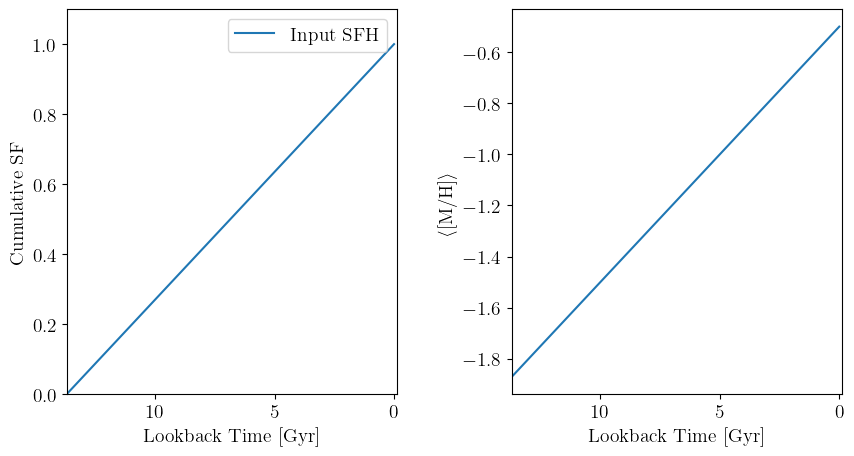

PyObject Text(457.3650849792141, 0.5, '$\\langle$[M/H]$\\rangle$')

In [26]:
fig,axs=plt.subplots(nrows=1,ncols=2,sharex=true,sharey=false,figsize=(10,5))
fig.subplots_adjust(hspace=0.0,wspace=0.35)

axs[1].plot( vcat(exp10.(unique_template_logAge)./1e9, T_max), vcat(cum_sfr_arr, 0.0), label="Input SFH" )

axs[1].set_xlim([T_max,-0.1])
axs[1].set_ylim([0.0,1.1])
axs[1].set_xlabel("Lookback Time [Gyr]")
axs[1].set_ylabel("Cumulative SF")
axs[1].legend()

axs[2].plot( vcat(exp10.(unique_template_logAge)./1e9, T_max), vcat(mean_mh_arr, β), label="Input SFH" )
axs[2].set_xlabel("Lookback Time [Gyr]")
axs[2].set_ylabel(L"$\langle$[M/H]$\rangle$")

In [27]:
# Look at the unique values of the SFRs
unique(sfr_arr)

9-element Vector{Float64}:
 0.0007301391778410239
 0.0007301391778410242
 0.0007301391778410241
 0.0007301391778410237
 0.0007301391778410238
 0.000730139177841024
 0.0007301391778410244
 0.0007301391778410243
 0.0007301391778410236

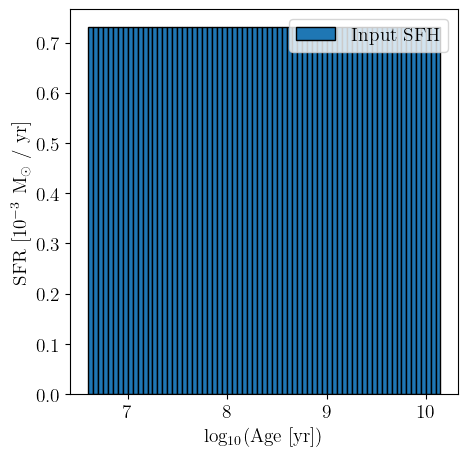

PyObject <matplotlib.legend.Legend object at 0x7f74e81414e0>

In [28]:
fig,ax1 = plt.subplots()
ax1.bar(unique_template_logAge, sfr_arr .* 1e3; width=diff(vcat(unique_template_logAge,max_logAge)), align="edge", label="Input SFH")
ax1.set_xlabel(L"log$_{10}$(Age [yr])")
ax1.set_ylabel(L"SFR [$10^{-3}$ M$_\odot$ / yr]")
ax1.set_ylim([0.0, ax1.get_ylim()[2]])
ax1.legend()

Now let's make a model Hess diagram with this SFH. We can simply write `composite = sum( coeffs .* models)` if we want, but we also provide the `composite!` function that is more efficient.

In [29]:
model1 = sum( x0 .* templates)

99×99 Matrix{Float64}:
 0.0          0.0          0.0          …  0.0          0.0
 0.0          0.0          0.0             0.0          0.0
 0.0          0.0          0.0             0.0          0.0
 0.0          0.0          0.0             0.0          0.0
 0.0          0.0          0.0             0.0          0.0
 0.0          0.0          0.0          …  0.0          0.0
 0.0          0.0          0.0             0.0          0.0
 5.40348e-64  1.1489e-17   1.68644e-14     0.0          0.0
 8.79792e-62  1.85824e-15  2.695e-12       0.0          0.0
 9.51394e-9   6.42556e-8   1.85539e-7      0.0          0.0
 4.08655e-7   2.63458e-6   4.70605e-6   …  1.36809e-60  5.05902e-67
 9.09277e-6   3.88866e-5   5.59208e-5      3.30775e-27  4.88989e-28
 9.4817e-5    0.000273266  0.00036055      8.82855e-17  1.02195e-19
 ⋮                                      ⋱               
 0.093715     0.124497     0.169652        8.50135e-5   4.59165e-5
 0.122256     0.162978     0.209807        5.8314

In [30]:
model2 = similar(model1)
import StarFormationHistories: composite!
composite!(model2, x0, templates)
model2

99×99 Matrix{Float64}:
 0.0          0.0          0.0          …  0.0          0.0
 0.0          0.0          0.0             0.0          0.0
 0.0          0.0          0.0             0.0          0.0
 0.0          0.0          0.0             0.0          0.0
 0.0          0.0          0.0             0.0          0.0
 0.0          0.0          0.0          …  0.0          0.0
 0.0          0.0          0.0             0.0          0.0
 5.40348e-64  1.1489e-17   1.68644e-14     0.0          0.0
 8.79792e-62  1.85824e-15  2.695e-12       0.0          0.0
 9.51394e-9   6.42556e-8   1.85539e-7      0.0          0.0
 4.08655e-7   2.63458e-6   4.70605e-6   …  1.36809e-60  5.05902e-67
 9.09277e-6   3.88866e-5   5.59208e-5      3.30775e-27  4.88989e-28
 9.4817e-5    0.000273266  0.00036055      8.82855e-17  1.02195e-19
 ⋮                                      ⋱               
 0.093715     0.124497     0.169652        8.50135e-5   4.59165e-5
 0.122256     0.162978     0.209807        5.8314

In [31]:
model1 ≈ model2

true

Let's plot the smooth model.

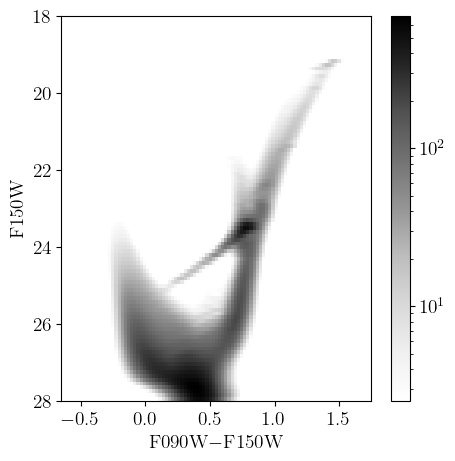

PyObject <matplotlib.colorbar.Colorbar object at 0x7f74e8b16350>

In [32]:
fig,ax1=plt.subplots()

im1=ax1.imshow(permutedims(model2), origin="lower", 
    extent=(extrema(edges[1])..., extrema(edges[2])...), 
    aspect="auto", cmap="Greys", norm=plt.matplotlib.colors.LogNorm(vmin=2.5), rasterized=true) 
ax1.set_xlabel(L"F090W$-$F150W")
ax1.set_ylabel("F150W")
ax1.set_ylim(reverse(extrema(edges[2]))) 
ax1.set_xlim(extrema(edges[1]))
fig.colorbar(im1)

## Sampling Methods for CMDs and Hess Diagrams

The templates are constructed such that the 2D histogram pixel values give the expected number of stars in that bin for a population with total stellar mass `normalize_value` (in our case we defined the variable `template_norm=1e3` and used that as our `normalize_value` for the templates). As such the pixel values of this complex model also represent expected numbers of stars per bin for our defined SFH. We may, therefore, simply Poisson sample it to obtain a reasonable observational realization of the Hess diagram:

In [33]:
import Distributions: Poisson
import Random: AbstractRNG, default_rng
function poisson_sample!(sample::T, model::S, rng::AbstractRNG=default_rng()) where {T <: AbstractArray{<:Number}, S <: AbstractArray{<:Number}}
    @assert axes(sample) == axes(model)
    for i in eachindex(sample, model)
        sample[i] = rand(rng,Poisson(model[i]))
    end
end
poisson_sample(model::AbstractArray{<:Number}, rng::AbstractRNG=default_rng()) = (sample = similar(model); poisson_sample!(sample, model, rng); return sample)
model3 = poisson_sample(model2)

99×99 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

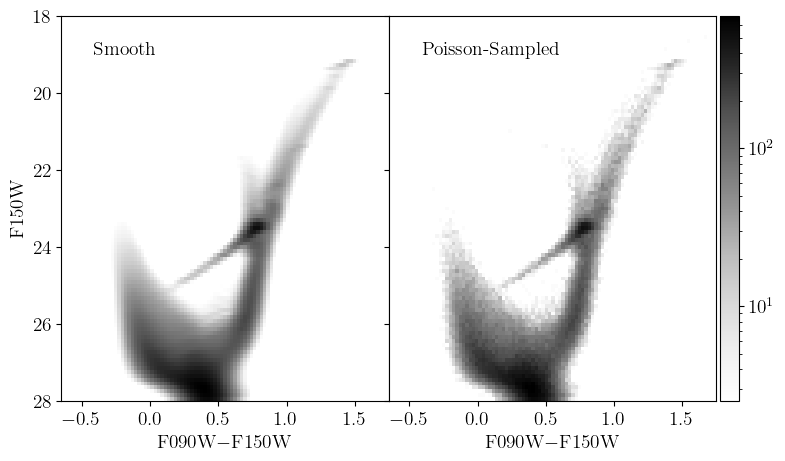

PyObject <matplotlib.colorbar.Colorbar object at 0x7f74e5771420>

In [34]:
fig,axs=plt.subplots(nrows=1,ncols=2,sharex=true,sharey=true,figsize=(10,5))
fig.subplots_adjust(hspace=0.0,wspace=0.0)

im1=axs[1].imshow(permutedims(model2), origin="lower", 
    extent=(extrema(edges[1])..., extrema(edges[2])...), 
    aspect="auto", cmap="Greys", norm=plt.matplotlib.colors.LogNorm(vmin=2.5), rasterized=true) 
axs[1].text(0.1,0.9,"Smooth",transform=axs[1].transAxes)
axs[2].imshow(permutedims(model3), origin="lower", 
    extent=(extrema(edges[1])..., extrema(edges[2])...), 
    aspect="auto", cmap="Greys", norm=plt.matplotlib.colors.LogNorm(vmin=2.5,vmax=im1.get_clim()[2]), rasterized=true) 
axs[2].text(0.1,0.9,"Poisson-Sampled",transform=axs[2].transAxes)
axs[1].set_xlabel(L"F090W$-$F150W")
axs[2].set_xlabel(L"F090W$-$F150W")
axs[1].set_ylabel("F150W")
axs[1].set_ylim(reverse(extrema(edges[2]))) 
axs[1].set_xlim(extrema(edges[1]))
fig.colorbar(im1, ax=axs, pad=0.005)

To sample the color-magnitude diagram (CMD) directly we could use `generate_stars_mass_composite`,

In [35]:
import StarFormationHistories: generate_stars_mass_composite
@time starcat = generate_stars_mass_composite(template_mini, template_isomags, ["F090W", "F150W"], stellar_mass, x0, imf; 
                                              dist_mod=distmod, binary_model=binary_model)

  2.258217 seconds (4.99 M allocations: 1.160 GiB, 2.10% gc time, 330.25% compilation time)


(Vector{StaticArraysCore.SVector{2, Float64}}[[[0.602836006504568, 0.0]], [[0.39302224462286917, 0.0]], [[0.23803436535211742, 0.0]], [[0.582718591113463, 0.0]], [[0.2460596471398033, 0.0]], [[0.5183840215795765, 0.0]], [[0.19349118370276422, 0.0]], [[0.14077858777398147, 0.0]], [[0.2343139581240549, 0.0]], [[0.10344269027686466, 0.0]]  …  [[0.2330929571602882, 0.0]], [[0.11220097719935143, 0.0]], [[0.23611223391744898, 0.0]], [], [[0.1448442646372922, 0.0]], [[0.19577632322532562, 0.10848111799421307]], [[0.5517387274199562, 0.0]], [[0.25371143407679136, 0.09157683493949993]], [[0.3935897584019476, 0.3043456637814438]], [[0.12497087468662814, 0.0]]], Vector{StaticArraysCore.SVector{2, Float64}}[[[29.75407066007857, 28.94842275578724]], [[30.43600238030495, 29.544724592386764]], [[31.183081682641994, 30.17837387704299]], [[29.810491848067613, 28.994536566272675]], [[31.159438690863233, 30.113012576540363]], [[30.023442500915433, 29.14105822191084]], [[31.538889923258857, 30.43178267205

We'll concatenate the per-population samples returned from `generate_stars_mass_composite` into a single `Vector{SVector}`. 

In [36]:
# starcat_mags = reduce(hcat,reduce(vcat,starcat[2])) # To make a 2D matrix
starcat_mags = reduce(vcat,starcat[2])

11861263-element Vector{StaticArraysCore.SVector{2, Float64}}:
 [29.75407066007857, 28.94842275578724]
 [30.43600238030495, 29.544724592386764]
 [31.183081682641994, 30.17837387704299]
 [29.810491848067613, 28.994536566272675]
 [31.159438690863233, 30.113012576540363]
 [30.023442500915433, 29.14105822191084]
 [31.538889923258857, 30.43178267205469]
 [31.991730156170455, 30.841211602781687]
 [31.288735429848266, 30.1654040070757]
 [32.42996938220384, 31.236934920780904]
 [31.72263584080963, 30.553042978165735]
 [30.490518477110953, 29.36310340972399]
 [29.170889106898827, 28.34224075628732]
 ⋮
 [32.185606416301624, 31.078823738979988]
 [34.8313039807046, 33.64098825127086]
 [35.6368099543945, 34.384924433089544]
 [34.06020114831955, 32.8760097524788]
 [36.205513559757, 34.817908402151716]
 [34.172501392340315, 32.938177781026184]
 [35.633039223392366, 34.16878192226898]
 [34.7325216855572, 33.26128838100799]
 [31.910873178576573, 30.696055504848744]
 [34.37072335359247, 32.9064878979242

In [37]:
println(@sprintf("Number of sampled stars is %.2e",length(starcat_mags)))
println(@sprintf("Stellar mass of sampled system at birth was %.2e",stellar_mass))
println(@sprintf("Present-day stellar mass of sampled system is %.2e",sum(reduce(vcat,starcat[1]))[1]))
import StarFormationHistories: mag2flux, flux2mag
println(@sprintf("Absolute magnitude of sampled system is M_{F090W} = %.2f",flux2mag( sum( x -> mag2flux(first(x)), starcat_mags) ) - distmod))

Number of sampled stars is 1.19e+07
Stellar mass of sampled system at birth was 1.00e+07
Present-day stellar mass of sampled system is 5.93e+06
Absolute magnitude of sampled system is M_{F090W} = -13.30


The number of sampled stars is very large as we have not imposed a faint-end magnitude cut, which is supported through the `mag_lim` and `mag_lim_name` keyword arguments. However, the sampling is still very fast.

Now we'll mock observe the "pure" catalog with the same observational models we used to construct the templates using `model_cmd`.

In [38]:
# Construct new / read cached catalog (for reproducibility)
import StarFormationHistories: model_cmd
read_obs_mags::Bool = true
if read_obs_mags
    if binary_model isa NoBinaries
        obs_mags = CSV.read(joinpath(@__DIR__, ".ipynb_checkpoints/obs_mags.txt"), Table; delim=' ', header=1)
    else
        obs_mags = CSV.read(joinpath(@__DIR__, ".ipynb_checkpoints/obs_mags_binaries.txt"), Table; delim=' ', header=1)
    end
    obs_mags = permutedims([obs_mags.F090W obs_mags.F150W])
else
    # Apply observational effects to "pure" catalog
    obs_mags = model_cmd( starcat_mags, [F090W_error, F150W_error], [F090W_complete, F150W_complete])
    # Concatenate into 2D matrix
    obs_mags = reduce(hcat,obs_mags)
    # Optionally write out to file; use .ipynb_checkpoints to prevent commit to github
    write_obs_mags::Bool = false
    if write_obs_mags
        CSV.write(joinpath(@__DIR__,".ipynb_checkpoints/obs_mags_binaries.txt"), Table(F090W=obs_mags[1,:], F150W=obs_mags[2,:]); delim=' ')
    end
end
display(obs_mags)

2×214975 Matrix{Float64}:
 27.8238  28.9519  23.2301  26.6281  …  29.0557  27.0229  27.4408  21.6945
 27.2647  28.1453  23.5305  26.232      28.6     26.2704  26.7373  20.5931

Now we'll compute the Hess diagram with `bin_cmd` and compare with our smooth and Poisson-sampled versions. 

In [39]:
# Total number of stars in the observed CMD space
count( obs_mags[2,:] .< maximum(edges[2]) )

179044

In [40]:
import StarFormationHistories: bin_cmd
model4 = bin_cmd(view(obs_mags,1,:) .- view(obs_mags,2,:), view(obs_mags,2,:), edges=edges).weights

99×99 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

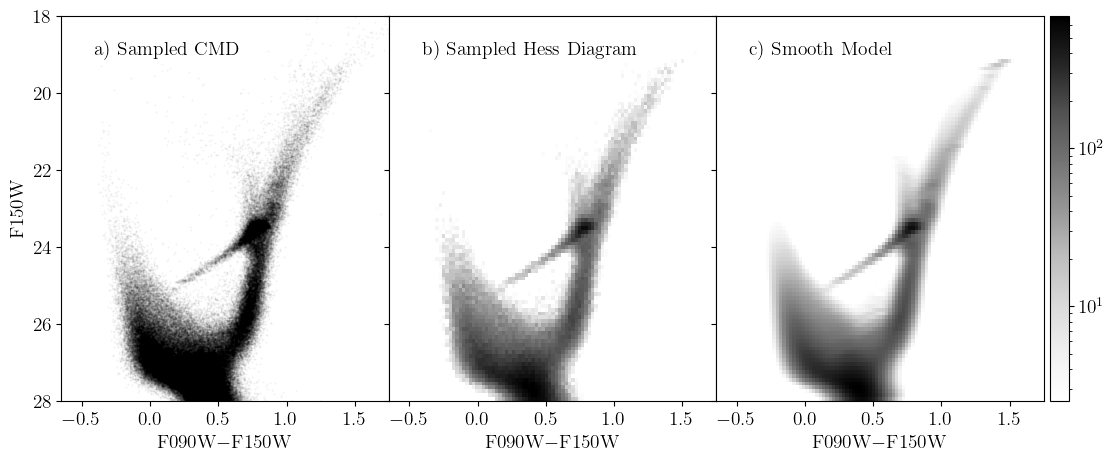

PyObject <matplotlib.colorbar.Colorbar object at 0x7f74e5562560>

In [41]:
fig,axs=plt.subplots(nrows=1,ncols=3,sharex=true,sharey=true,figsize=(15,5))
fig.subplots_adjust(hspace=0.0,wspace=0.0)

im1=axs[3].imshow(permutedims(model2), origin="lower", 
    extent=(extrema(edges[1])..., extrema(edges[2])...), 
    aspect="auto", cmap="Greys", norm=plt.matplotlib.colors.LogNorm(vmin=2.5), rasterized=true)
axs[3].text(0.1,0.9,"c) Smooth Model",transform=axs[3].transAxes)
axs[1].scatter(view(obs_mags,1,:) .- view(obs_mags,2,:), view(obs_mags,2,:), s=1, marker=".", c="k", alpha=0.05, rasterized=true, label="CMD-Sampled")
axs[1].text(0.1,0.9,"a) Sampled CMD",transform=axs[1].transAxes)
axs[2].imshow(permutedims(model4), origin="lower", 
    extent=(extrema(edges[1])..., extrema(edges[2])...), 
    aspect="auto", cmap="Greys", norm=plt.matplotlib.colors.LogNorm(vmin=2.5,vmax=im1.get_clim()[2]), rasterized=true, label="CMD-Sampled")
axs[2].text(0.1,0.9,"b) Sampled Hess Diagram",transform=axs[2].transAxes)

axs[1].set_xlabel(L"F090W$-$F150W")
axs[2].set_xlabel(L"F090W$-$F150W")
axs[3].set_xlabel(L"F090W$-$F150W")
axs[1].set_ylabel("F150W")
axs[1].set_ylim(reverse(extrema(edges[2]))) 
axs[1].set_xlim(extrema(edges[1]))

fig.colorbar(im1, ax=axs, pad=0.005)
# plt.savefig("mcsample_example.pdf",bbox_inches="tight")
# fig.colorbar(im1)

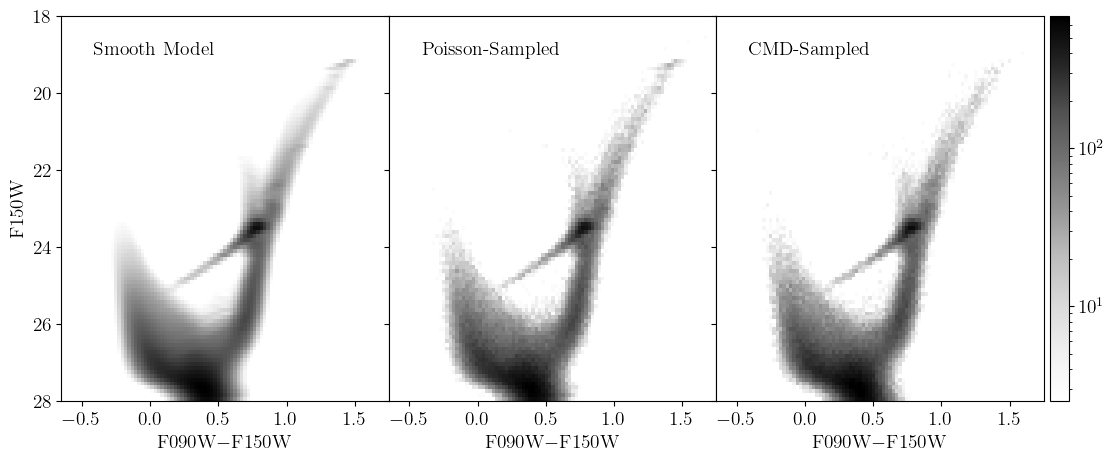

PyObject <matplotlib.colorbar.Colorbar object at 0x7f74c372ad70>

In [42]:
fig,axs=plt.subplots(nrows=1,ncols=3,sharex=true,sharey=true,figsize=(15,5))
fig.subplots_adjust(hspace=0.0,wspace=0.0)

im1=axs[1].imshow(permutedims(model2), origin="lower", 
    extent=(extrema(edges[1])..., extrema(edges[2])...), 
    aspect="auto", cmap="Greys", norm=plt.matplotlib.colors.LogNorm(vmin=2.5), rasterized=true) 
axs[1].text(0.1,0.9,"Smooth Model",transform=axs[1].transAxes)
axs[2].imshow(permutedims(model3), origin="lower", 
    extent=(extrema(edges[1])..., extrema(edges[2])...), 
    aspect="auto", cmap="Greys", norm=plt.matplotlib.colors.LogNorm(vmin=2.5,vmax=im1.get_clim()[2]), rasterized=true) 
axs[2].text(0.1,0.9,"Poisson-Sampled",transform=axs[2].transAxes)
axs[3].imshow(permutedims(model4), origin="lower", 
    extent=(extrema(edges[1])..., extrema(edges[2])...), 
    aspect="auto", cmap="Greys", norm=plt.matplotlib.colors.LogNorm(vmin=2.5,vmax=im1.get_clim()[2]), rasterized=true, label="CMD-Sampled") 
axs[3].text(0.1,0.9,"CMD-Sampled",transform=axs[3].transAxes)

axs[1].set_xlabel(L"F090W$-$F150W")
axs[2].set_xlabel(L"F090W$-$F150W")
axs[3].set_xlabel(L"F090W$-$F150W")
axs[1].set_ylabel("F150W")
axs[1].set_ylim(reverse(extrema(edges[2]))) 
axs[1].set_xlim(extrema(edges[1]))
fig.colorbar(im1, ax=axs, pad=0.005)

The mock Hess diagram created by Poisson-sampling the smooth model (labelled "Poisson-Sampled") and the Hess diagram created by sampling stars via `generate_stars_mass_composite` and mock observing them with `model_cmd` (labelled "CMD-Sampled") are highly consistent. The Poisson-sampled method is more efficient if a Hess diagram is all that is required, but if you need individual stars (e.g., for forming a star catalog for injection into images) then you should go the CMD-sampled route.

In [43]:
# Choose which sampled Hess diagram to use for model fitting; choosing CMD-sampled instance here.
data = model4

99×99 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

## SFH Fitting: Constrained Metallicity Evolution

Given that we constructed our model population with a linear [M/H] AMR, it will be optimally recovered when fitting under the same general AMR model. This can be achieved by using the generic `fit_sfh` function with the `LinearAMR` metallicity model and the `GaussianDispersion` dispersion model to fit the SFH simultaneously with the AMR.

Note that in real data, the parameter σ (which sets the width of the metallicity distribution function at fixed age) can be difficult to constrain. As such, it is often preferable to fix σ rather than fitting it. For the purposes of this example, we will allow σ to be fit to show it can be recovered robustly in the case of synthetic data.

In [44]:
import StarFormationHistories: fit_sfh, LinearAMR, GaussianDispersion
mdf_α, mdf_β, mdf_σ = 0.15, -2.25, 0.2 # -0.15, -0.2, 0.2 # initial guess for the metallicity evolution parameters
mdf_result = fit_sfh(LinearAMR(mdf_α, mdf_β, T_max),
                     GaussianDispersion(0.2),
                     templates,
                     data,
                     template_logAge, template_MH;
                     x0=construct_x0_mdf(template_logAge, T_max; normalize_value=1e4))

StarFormationHistories.CompositeBFGSResult{StarFormationHistories.BFGSResult{Vector{Float64}, Vector{Float64}, PDMats.PDMat{Float64, Matrix{Float64}}, Optim.MultivariateOptimizationResults{Optim.BFGS{LineSearches.InitialStatic{Float64}, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}, Nothing, Nothing, Optim.Flat}, Vector{Float64}, Float64, Float64, Vector{Optim.OptimizationState{Float64, Optim.BFGS{LineSearches.InitialStatic{Float64}, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}, Nothing, Nothing, Optim.Flat}}}, Bool, @NamedTuple{f_limit_reached::Bool, g_limit_reached::Bool, h_limit_reached::Bool, time_limit::Bool, callback::Bool, f_increased::Bool}}, LinearAMR{Float64}, GaussianDispersion{Float64}}, StarFormationHistories.BFGSResult{Vector{Float64}, Vector{Float64}, LinearAlgebra.Hermitian{Float64, Matrix{Float64}}, Optim.MultivariateOptimizationResults{Optim.BFGS{LineSearches.InitialStatic{Float64}, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}, Nothing, Nothi

We will now calculate the per-template coefficients using `calculate_coeffs`, which we can use as input for other methods like `calculate_cum_sfr`, which computes cumulative SFHs, SFRs, and <[M/H]> from the fitted coefficients. We can use our result from `fit_sfh` directly in the call to `calculate_coeffs`. If we call `calculate_coeffs(mdf_result, ...)` it will use the MLE result for the best-fit values. We can alternatively pass call `calculate_coeffs(mdf_result.map, ...)` to use the MAP result instead.

In [45]:
mdf_coeffs = calculate_coeffs(mdf_result.map, template_logAge, template_MH)
mdf_coeffs *= template_norm
            
_, mdf_cum_sfr_arr, mdf_sfr_arr, mdf_mean_mh_arr =
    calculate_cum_sfr(mdf_coeffs, template_logAge, template_MH, T_max)

([6.6, 6.65, 6.7, 6.75, 6.8, 6.85, 6.9, 6.95, 7.0, 7.05  …  9.65001, 9.70001, 9.75001, 9.80001, 9.85001, 9.90001, 9.95001, 10.00001, 10.05001, 10.10001], [0.9999999999999998, 0.9997223365797941, 0.9996357959350763, 0.9995521606845409, 0.9994548996835425, 0.9993313562416706, 0.9991846782053404, 0.9989316729530312, 0.9987217909688955, 0.9984637721071453  …  0.6822235721188221, 0.6297872944804435, 0.5911544532677411, 0.5581273304933472, 0.4629850721646168, 0.4290555560651026, 0.34595810491628587, 0.2712757441835005, 0.17717935714510769, 0.09207045766633874], [0.00586863745638014, 0.0016301919287618856, 0.0014041321211743748, 0.0014553161445431005, 0.0016475488817316382, 0.0017433464407234844, 0.002680082415934947, 0.001981498616478578, 0.0021710512085235975, 0.0018045843372968095  …  0.0009877350533333091, 0.0006485825521496454, 0.0004941733867156731, 0.001268767565839232, 0.0004032610513698563, 0.0008802303020104885, 0.0007050609307013549, 0.0007917381293718258, 0.000638239365265749, 0.0

Of additional note are the uncertainty estimates, available as `mdf_result.map.σ` and `mdf_result.mle.σ`. These are essentially standard errors derived from the diagonal of the covariance matrix of the fitting parameters (discussed more below). The `mdf_result.map` result contains the maximum a posteriori result and is often very comparable to the mode of posterior samples obtained via Hamiltonian Monte Carlo (provided by `sample_sfh`). We don't generally recommend the use of `mdf_result.mle.σ` because the estimate of the covariance matrix obtained during the BFGS fit can be poorly conditioned when best-fit SFRs are 0, but we provide it for completeness.

In [46]:
mdf_result.mle.μ

74-element Vector{Float64}:
    4.503006051366787
    2.309907151940367e-23
    1.6217568662788475e-24
    6.139998279470846e-21
    8.509206679847138e-53
    4.7806033254260056e-64
    6.533423420804538
    2.4741048291067253e-45
    8.754625663304788
    1.8238830235398162
    2.2735852230753333e-30
    6.09274530204169e-22
    8.949039764457536e-21
    ⋮
  421.22221930344364
  126.94594002529965
 1333.4049688999933
  110.77712625978579
  890.3590046072976
  757.7130653654132
  978.433862196377
  873.6680517499103
  946.5902458076688
    0.100257361634675
   -1.870423274970492
    0.11462347088972348

In [47]:
import Measurements: uncertainty, ±
mdf_result.map.μ .± mdf_result.map.σ

74-element Vector{Measurements.Measurement{Float64}}:
     2.9 ± 1.1
    0.89 ± 0.85
    0.86 ± 0.83
     1.0 ± 0.95
     1.3 ± 1.2
     1.5 ± 1.4
     2.6 ± 2.1
     2.2 ± 2.0
     2.6 ± 2.3
     2.5 ± 2.1
     1.3 ± 1.3
     1.3 ± 1.2
     1.1 ± 1.1
         ⋮
   400.0 ± 200.0
   340.0 ± 200.0
   980.0 ± 280.0
   350.0 ± 190.0
   850.0 ± 140.0
   770.0 ± 150.0
   970.0 ± 110.0
   874.0 ± 74.0
   945.0 ± 50.0
  0.1003 ± 0.00051
 -1.8706 ± 0.0056
  0.1146 ± 0.0023

### Sampling from Inverse Hessian 

Another thing we can do is draw samples from the posterior approximating the posterior distribution as Gaussians and the inverse Hessian as its variance-covariance matrix. This is preferred to using the standard error uncertainties in `mdf_result.map.σ` as samples will include covariances. There are additional notes in the documentation on this approximation, but this sampling method often reproduces results from more expensive Monte Carlo sampling methods fairly well. In short, we are approximating the posterior (in the transformed fitting variables `θ = log(coeffs)`) as a multivariate Gaussian in the region of the MAP estimate. For a multivariate Gaussian, the inverse of the Hessian matrix (which the BFGS algorithm from Optim.jl computes for us) is an estimator for the variance-covariance matrix. In concert with the MAP estimate for the parameters, this gives us both the means μ and the variance-covariance matrix Σ needed to define our multivariate Gaussian approximation of the posterior, which we can then sample from using `MvNormal` from Distributions.jl.

`N` samples can be drawn using the methodology described above by calling `rand(result, N)` where `result` is either a `CompositeBFGSResult` or a `BFGSResult`.

In [48]:
import Statistics: mean, median, quantile

In [49]:
# # This is effectively what rand(mdf_result.map, 10000) is doing.
# import Distributions: MvNormal
# import LinearAlgebra: Hermitian
# import Optim
# mdf_dist = MvNormal(Optim.minimizer(mdf_result.mle.result),
#                     Hermitian(Optim.trace(mdf_result.map.result)[end].metadata["~inv(H)"]))
# mdf_sample = rand(mdf_dist, 10000)

# # Transform the variables, noting that the stellar mass coefficients `mdf_sample[begin:end-3,:]` 
# # and σ `mdf_sample[end,:]` are fit with logarithmic transformations so we have to transform them back.
# # α and β are optimized directly, without a transformation.
# @views mdf_sample[begin:end-3,:] .= exp.(mdf_sample[begin:end-3,:]) .* template_norm
# @views mdf_sample[end-2,:] .= exp.(mdf_sample[end-2,:])
# @views mdf_sample[end,:] .= exp.(mdf_sample[end,:])
# mdf_sample

In [50]:
mdf_sample = rand(mdf_result.map, 10000)
@views mdf_sample[begin:end-3,:] *= template_norm # Correct the stellar mass coefficients for the template normalization
# Calculate the cumulative SFH for each point in the sample
# and find the 1-σ range
mdf_cum_sfr = Vector{Vector{Float64}}(undef,0)
mdf_sfr = Vector{Vector{Float64}}(undef,0)
mdf_mh = Vector{Vector{Float64}}(undef,0)
for x in eachcol(mdf_sample)
    tmp_coeffs = calculate_coeffs(LinearAMR((@view x[end-2:end-1])..., T_max), GaussianDispersion(x[end]), @view(x[begin:end-3]), 
                                  template_logAge, template_MH)
    _, mdf_1, mdf_2, mdf_3 = calculate_cum_sfr(tmp_coeffs, template_logAge, template_MH, T_max)
    push!(mdf_cum_sfr, mdf_1)
    push!(mdf_sfr, mdf_2)
    push!(mdf_mh, mdf_3)
end
mdf_cum_sfr = reduce(hcat, mdf_cum_sfr) 
mdf_sfr = reduce(hcat, mdf_sfr) 
mdf_mh = reduce(hcat, mdf_mh) 

# Now calculate quantiles
mdf_cum_lower = quantile.(eachrow(mdf_cum_sfr), 0.16)
mdf_cum_med = median.(eachrow(mdf_cum_sfr))
mdf_cum_upper = quantile.(eachrow(mdf_cum_sfr), 0.84)
mdf_sfr_lower = quantile.(eachrow(mdf_sfr), 0.16)
mdf_sfr_med = median.(eachrow(mdf_sfr))
mdf_sfr_upper = quantile.(eachrow(mdf_sfr), 0.84)
mdf_mh_lower = quantile.(eachrow(mdf_mh), 0.16)
mdf_mh_med = median.(eachrow(mdf_mh))
mdf_mh_upper = quantile.(eachrow(mdf_mh), 0.84);

We can look at the sampled values for the AMR slope α, intercept β, and MDF width σ:

In [51]:
println((α, β, σ))
mdf_sample[end-2:end,:]

(0.1, -1.87, 0.1)


3×10000 Matrix{Float64}:
  0.0992832   0.100068   0.101225  …   0.0998089   0.100756   0.100894
 -1.85934    -1.86814   -1.88047      -1.86539    -1.87355   -1.87784
  0.110859    0.114228   0.112381      0.110796    0.113548   0.11746

Note that `cum_sfr_quantiles` is available to simplify the above process of calculating SFH quantiles from samples.

We can look at the marginal distributions of the metallicity variables using the "corner" python package:

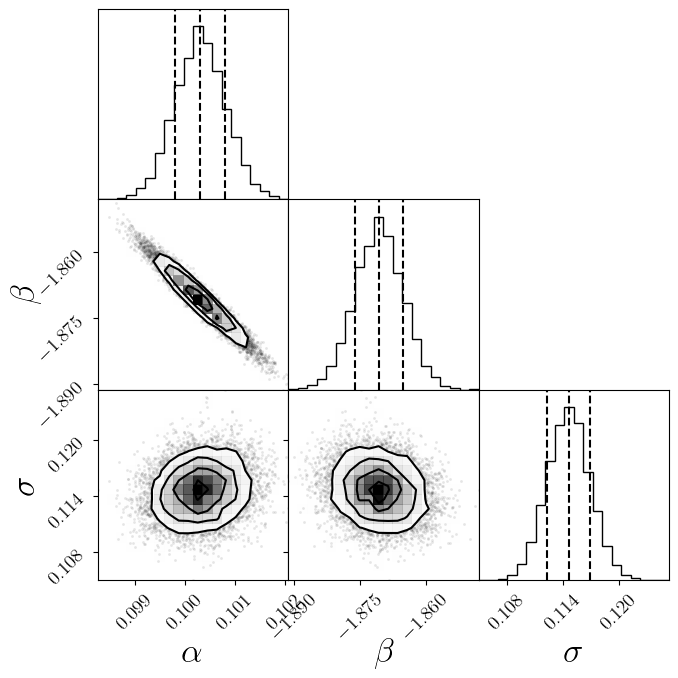

In [52]:
@pyimport corner # Easy marginal distributions
fig=plt.figure(figsize=(7,7))
# fig.suptitle("Linear M/H")
corner.corner( permutedims(@view mdf_sample[end-2:end,:]),
                fig=fig,
                labels=[L"\alpha", L"\beta", L"\sigma"],
                quantiles=[0.16,0.5,0.84],
                max_n_ticks=4,
                show_titles=false,
                title_kwargs=Dict("fontsize"=>17),
                label_kwargs=Dict("fontsize"=>25))
fig.subplots_adjust(hspace=0.0, wspace=0.0)

We see that the inverse Hessian has captured some covariance between the parameters. Now we'll plot the cumulative SFH and metallicity evolution.

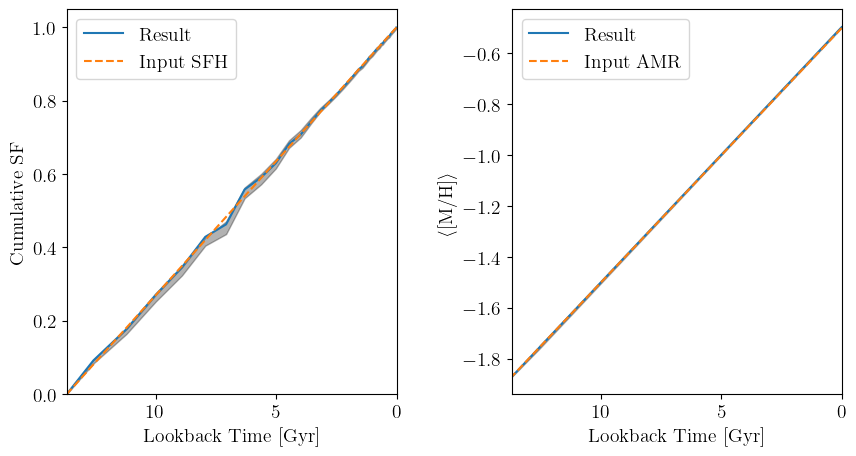

PyObject <matplotlib.legend.Legend object at 0x7f74c3e03580>

In [53]:
# Now plot cumulative SFH and MH evolution for the metallicity evolution model
fig,axs=plt.subplots(nrows=1,ncols=2,sharex=true,sharey=false,figsize=(10,5))
fig.subplots_adjust(hspace=0.0,wspace=0.35)

axs[1].plot( vcat(exp10.(unique_template_logAge)./1e9, T_max), vcat(mdf_cum_sfr_arr,0.0), label="Result" ) # This is MAP result
# axs[1].plot( exp10.(unique_template_logAge)./1e9, mdf_cum_med, label="Result" ) # This is median of samples
axs[1].plot( vcat(exp10.(unique_template_logAge)./1e9, T_max), vcat(cum_sfr_arr,0.0), label="Input SFH", ls="--" )
axs[1].fill_between( vcat(exp10.(unique_template_logAge)./1e9, T_max), vcat(mdf_cum_lower,0.0), vcat(mdf_cum_upper,0.0), alpha=0.3, fc="k")

axs[1].set_xlim([T_max,0.0])
axs[1].set_ylim([0.0,1.05])
axs[1].set_xlabel("Lookback Time [Gyr]")
axs[1].set_ylabel("Cumulative SF")
axs[1].legend()

axs[2].plot( vcat( exp10.(unique_template_logAge)./1e9, T_max), vcat(mdf_mh_med, mdf_result.map.μ[end-1]), label="Result" )
axs[2].fill_between( vcat(exp10.(unique_template_logAge)./1e9, T_max), vcat(mdf_mh_lower, mdf_result.map.μ[end-1]), vcat(mdf_mh_upper, mdf_result.map.μ[end-1]), alpha=0.3, fc="k")
axs[2].plot( vcat(exp10.(unique_template_logAge)./1e9, T_max), vcat(mean_mh_arr, β), label="Input AMR", ls="--" )

axs[2].set_xlabel("Lookback Time [Gyr]")
axs[2].set_ylabel(L"$\langle$[M/H]$\rangle$")
axs[2].legend()
# plt.savefig("example_cumsfh.pdf", bbox_inches="tight")

The above plots show that we are able to measure the cumulative SFH and age-metallicity relation simultaneously and that they are statistically consistent with the input model. We will now look at the SFRs in each log(Age) bin. 

In [54]:
[ vcat(exp10.(unique_template_logAge)./1e9, T_max) 1.0.-vcat(cum_sfr_arr,0.0) ]

72×2 Matrix{Float64}:
  0.00398107  3.33067e-16
  0.00446684  3.54675e-5
  0.00501187  7.52628e-5
  0.00562341  0.000119914
  0.00630957  0.000170013
  0.00707946  0.000226225
  0.00794328  0.000289297
  0.00891251  0.000360064
  0.01        0.000439466
  0.0112202   0.000528556
  0.0125893   0.000628517
  0.0141254   0.000740675
  0.0158489   0.000866519
  ⋮           
  3.98116     0.29039
  4.46694     0.325858
  5.01199     0.365654
  5.62354     0.410306
  6.30972     0.460407
  7.07962     0.51662
  7.94347     0.579693
  8.91271     0.650462
 10.0002      0.729865
 11.2204      0.818958
 12.5895      0.918921
 13.7         1.0

In [55]:
# Construct an interpolator that, given a fraction of total stellar mass `x`, will find the lookback time `t` 
# at which the fraction of stellar mass formed *more recently* than `t` is `x`.
import Interpolations: extrapolate, interpolate, Gridded, Linear, Flat
# recent_sfh_interp = extrapolate(interpolate((vcat(exp10.(unique_template_logAge)./1e9, T_max),), 1 .- vcat(cum_sfr_arr,0.0), Gridded(Linear())), Flat())
sfh_quantile = extrapolate(interpolate((1 .- vcat(cum_sfr_arr,0.0),), vcat(exp10.(unique_template_logAge)./1e9, T_max), Gridded(Linear())), Flat());

In [56]:
log10(sfh_quantile(0.001)) + 9

7.247410788638181

8.149038152771352
7.247410788638181


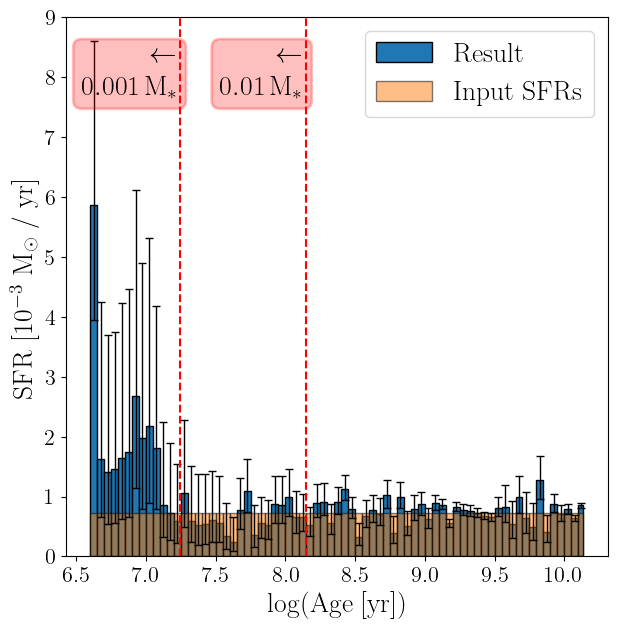

PyObject <matplotlib.legend.Legend object at 0x7f74c3c248e0>

In [57]:
# Now plot the SFRs for the metallicity evolution model
fig,ax1 = plt.subplots(figsize=(7,7))
ax1.tick_params(axis="both", which="both", labelsize=16)
# ax1.bar(unique_template_logAge, mdf_sfr_med .* 1e3; width=diff(vcat(unique_template_logAge,max_logAge)), align="edge", 
ax1.bar(unique_template_logAge, mdf_sfr_arr .* 1e3; width=diff(vcat(unique_template_logAge,max_logAge)), align="edge", 
    yerr = [(mdf_sfr_med .- mdf_sfr_lower) .* 1e3, 
            (mdf_sfr_upper .- mdf_sfr_med) .* 1e3], 
    capsize=3, error_kw=Dict("elinewidth"=>1,"capthick"=>1), label="Result")
ax1.bar(unique_template_logAge, sfr_arr .* 1e3; width=diff(vcat(unique_template_logAge,max_logAge)), align="edge", label="Input SFRs", alpha=0.5)

ax1.set_xlabel("log(Age [yr])", fontsize=20)
ax1.set_ylabel(L"SFR [$10^{-3}$ M$_\odot$ / yr]", fontsize=20)
ax1.set_ylim([0.0, 9.0]) # ax1.set_ylim([0.0, ax1.get_ylim()[2]])

# Draw vertical lines to denote times at which `x` fraction of stellar mass was formed more recently
for q in ("0.01", "0.001")
    laq = log10(sfh_quantile(parse(Float64, q))) + 9
    println(laq)
    ax1.axvline(laq, ls="--", c="red")
    # ax1.text( log10(sfh_quantile(qn)) + 9, ax1.get_ylim()[2] - 1, L"$\leftarrow$ \n $ %$q \text{M}_*$", transform=ax1.transData, ha="right", va="top")
    t = ax1.text(laq - 0.02, ax1.get_ylim()[2] - 0.5, "\$\\leftarrow\$ \n \$ $q \\, \\text{M}_*\$", transform=ax1.transData, ha="right", va="top", fontsize=20)
    t.set_bbox(Dict("facecolor"=>"red", "alpha"=>0.25, "edgecolor"=>"red", "lw"=>2, "boxstyle"=>"round"))
end
ax1.legend(fontsize=20)
# plt.savefig("example_sfrs_hires.pdf", bbox_inches="tight")

It is important to note that there can be strong covariances between the SFRs (or stellar mass coefficients) of neighboring time bins, as their templates can be very similar. We can calculate the correlation matrix of our posterior samples to examine these correlations.

In [58]:
import Statistics: cor
cor(mdf_sample[1:5,:]; dims=2)

5×5 Matrix{Float64}:
  1.0        -0.285024   -0.19777    -0.13857    -0.0998224
 -0.285024    1.0        -0.0331039  -0.0373696  -0.032796
 -0.19777    -0.0331039   1.0        -0.0411748  -0.0425882
 -0.13857    -0.0373696  -0.0411748   1.0        -0.0591129
 -0.0998224  -0.032796   -0.0425882  -0.0591129   1.0

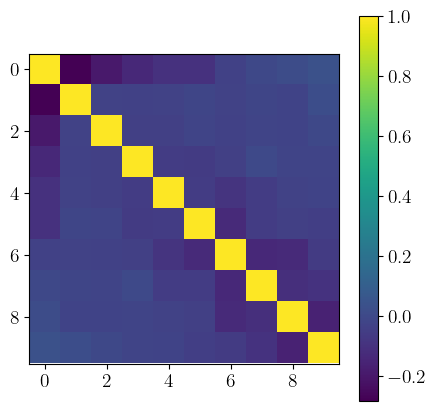

PyObject <matplotlib.colorbar.Colorbar object at 0x7f74c3abf8b0>

In [59]:
# Young stellar pops show minimal correlation
plt.imshow(cor(mdf_sample[1:10,:]; dims=2))
plt.colorbar()

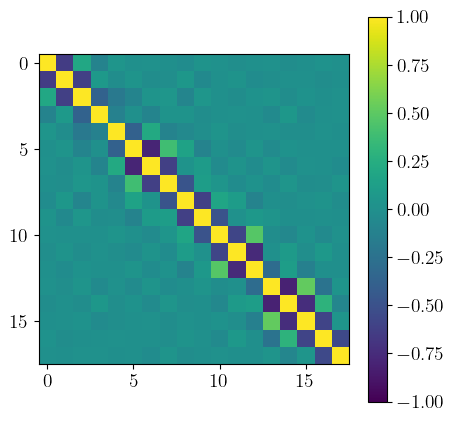

PyObject <matplotlib.colorbar.Colorbar object at 0x7f74c397e4a0>

In [60]:
# Old stellar pops show greater correlations
plt.imshow(cor(mdf_sample[end-20:end-3,:]; dims=2), clim=(-1,1))
plt.colorbar()

It can also be instructive to look at corner plots of the samples to examine their covariances,

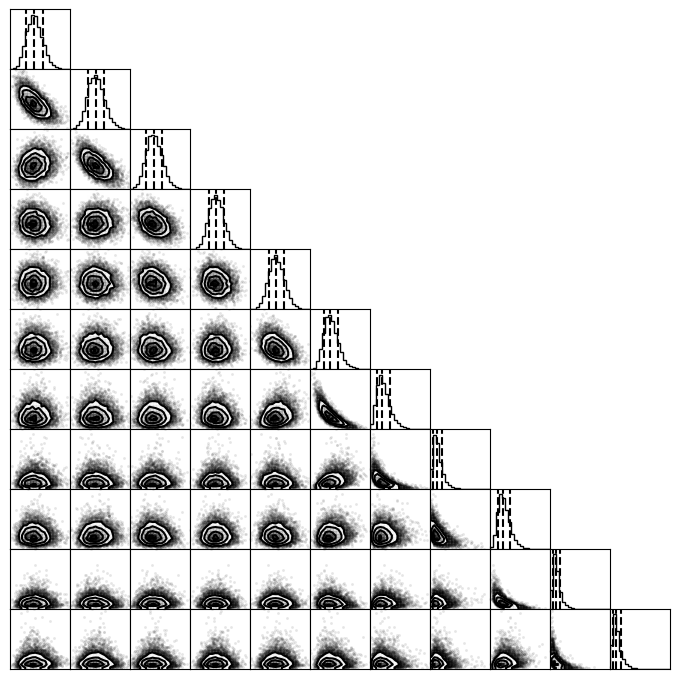

In [61]:
fig=plt.figure(figsize=(7,7))
corner.corner( permutedims(@view mdf_sample[end-20:end-10,:]) .* 1e3,
# corner.corner( permutedims(@view mdf_sfr_sample[1:5,:]) .* 1e3,
                fig=fig,
                quantiles=[0.16,0.5,0.84],
                max_n_ticks=0, # turn ticks off, illustrating shape only
                show_titles=false,
                title_kwargs=Dict("fontsize"=>17),
                label_kwargs=Dict("fontsize"=>25))
fig.subplots_adjust(hspace=0.0, wspace=0.0)

We can also look at the overall mass-weighted metallicity distribution function that results from the combination of our star formation history and our age-metallicity relation.

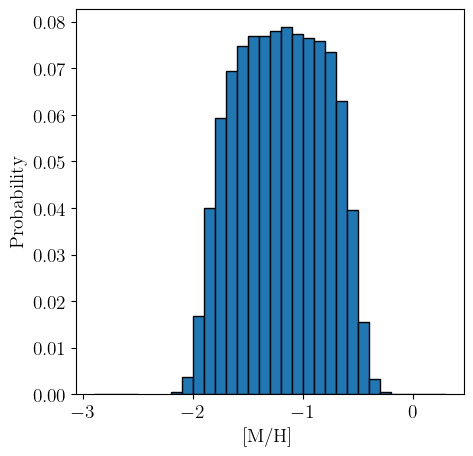

PyObject Text(27.219312263257578, 0.5, 'Probability')

In [62]:
# Make integrated MDF plot
import StarFormationHistories: mdf_amr
MDF_x, MDF = mdf_amr(mdf_coeffs, template_logAge, template_MH)
fig, ax1 = plt.subplots()
ax1.bar(MDF_x, MDF, -abs(MDF_x[2] - MDF_x[3]), align="edge", linewidth=1, edgecolor="k")
ax1.set_xlabel("[M/H]")
ax1.set_ylabel("Probability")

Overall the resulting fit is very consistent with the true values. We do, however, see that the SFRs at recent times (small log(Age)) are slightly higher than expected. This is in large part due to our grid being equally-spaced in log(Age) with a very fine time spacing ($\Delta$log(Age)$=0.1$). As such, the most recent time bins contain very little stellar mass. The total stellar mass for all bins with `logAge < 7` is 

In [63]:
# Equivalent to sum(mdf_coeffs[template_logAge .<= maximum(unique_template_logAge[1:5])])
# sum(mdf_result.map.μ[1:5] .* template_norm) 
sum(mdf_result.map.μ[findall(<(7), unique_logAge)] .* template_norm)

13123.389328137404

which is of order 0.1% of the stellar mass of the system.

In [64]:
sum(mdf_result.map.μ[findall(<(7), unique_logAge)] .* template_norm) / stellar_mass * 100

0.13123389328137405

### Examining the effects of observational systematics

Uncertainties in properties of the galaxy that we assume when constructing model templates (e.g., distance, MW foreground reddening, etc) should additionally be taken into consideration. We consider here what happens if we model the population with incorrect assumptions about these parameters.

In [145]:
# Try to use distributed rather than threads because threads use single global GC,
# distributed has a separate GC for each worker and so is more efficient for expensive iterations 
# that have a lot of allocations

In [146]:
@everywhere include("fitting1_synthetic_systematics.jl")
@everywhere using Distributions: Normal, Dirac, Uniform
@everywhere using StarFormationHistories: RandomBinaryPairs, Martin2016_complete, exp_photerr, LinearAMR, GaussianDispersion

In [147]:
# # 16 seconds
# # Basic function, which we will Monte Carlo sample on top of
# @time synthetic_systematics(template_mini, template_isomags, ["F090W", "F150W"], "F150W", stellar_mass, x0, imf,
#                       SVector(0.1, 0.05), [F090W_error, F150W_error], [F090W_complete, F150W_complete],
#                       edges, LinearAMR(mdf_α, mdf_β, T_max), GaussianDispersion(0.2),
#                       templates, template_logAge, template_MH; 
#                       dist_mod=distmod, binary_model=NoBinaries())

In [148]:
# # 
# # This works but we can't reuse [F090W_error, F150W_error], [F090W_complete, F150W_complete]
# # because we didn't define them as @everywhere above so we have to redefine the functions here
# sys_samples = distributed_systematics(Uniform(0.0, 0.15), # A_v distribution 
#                         SVector(0.4788075325936103, 0.21031702893243048), # A_λ / A_v from DustExtinction.CCM89 
#                         Uniform(0.0, 0.7), # Binary fraction distribution
#                         RandomBinaryPairs, # Binary fraction model
#                         Normal(distmod, 0.09), # WLM distance modulus is 24.93 ± 0.09, Albers+2019
#                         2, # Number of MC realizations to run 
#                         template_mini, template_isomags, ["F090W", "F150W"], "F150W", stellar_mass, x0, imf,
#                         [m->Martin2016_complete(m,1.0,28.5,0.7), m->Martin2016_complete(m,1.0,27.5,0.7)],
#                         [m->min( exp_photerr(m, 1.03, 15.0, 36.0, 0.02), 0.4 ), m->min( exp_photerr(m, 1.03, 15.0, 35.0, 0.02), 0.4 )],
#                         edges, LinearAMR(mdf_α, mdf_β, T_max), GaussianDispersion(0.2),
#                         templates, template_logAge, template_MH)

In [149]:
# Threaded version seems to be working fine but might be less memory efficient?
# 02:27:28 for 1_000 samples
using Serialization
run_systematics::Bool = false
if run_systematics
    sys_samples = threaded_systematics(
                            # Uniform(0.0, 0.10), # A_v distribution 
                            Uniform(-0.05, 0.05), # A_v distribution 
                            SVector(0.4788075325936103, 0.21031702893243048), # A_λ / A_v from DustExtinction.CCM89 
                            Uniform(0.0, 0.7), # Binary fraction distribution
                            RandomBinaryPairs, # Binary fraction model
                            # NoBinaries, # Binary fraction model
                            Normal(distmod, 0.09), # WLM distance modulus is 24.93 ± 0.09, Albers+2019
                            1_000, # Number of MC realizations to run 
                            template_mini, template_isomags, ["F090W", "F150W"], "F150W", stellar_mass, x0, imf,
                            [F090W_error, F150W_error], [F090W_complete, F150W_complete],
                            edges, LinearAMR(mdf_α, mdf_β, T_max), GaussianDispersion(0.2),
                            templates, template_logAge, template_MH, T_max, template_norm;
                            x0=construct_x0_mdf(template_logAge, T_max; normalize_value=1e4));
    # Serialize to temporary file to avoid rerunning
    serialize(joinpath(@__DIR__, ".ipynb_checkpoints/sys_samples.serial"), sys_samples)
else
    sys_samples = deserialize(joinpath(@__DIR__, ".ipynb_checkpoints/sys_samples.serial"))
end;

In [151]:
size(sys_samples)

(1000, 3, 71)

In [152]:
# Compute quantiles on statistics
# sys_quantiles = [quantile(view(sys_samples,:,1,i), SVector(0.16, 0.5, 0.84)) for i in axes(sys_samples,3)]
sys_cum_quantiles = permutedims(reduce(hcat, quantile(view(sys_samples,:,1,i), SVector(0.16, 0.5, 0.84)) for i in axes(sys_samples,3)))
sys_mh_quantiles = permutedims(reduce(hcat, quantile(view(sys_samples,:,3,i), SVector(0.16, 0.5, 0.84)) for i in axes(sys_samples,3)))

71×3 StaticArraysCore.SMatrix{71, 3, Float64, 213} with indices SOneTo(71)×SOneTo(3):
 -0.588667  -0.490768  -0.391009
 -0.588698  -0.49082   -0.391074
 -0.588733  -0.49088   -0.391147
 -0.588772  -0.490946  -0.391228
 -0.588816  -0.491021  -0.39132
 -0.588866  -0.491104  -0.391423
 -0.588921  -0.491198  -0.391538
 -0.588983  -0.491303  -0.391667
 -0.589053  -0.491422  -0.391812
 -0.589131  -0.491549  -0.391979
 -0.589218  -0.491681  -0.392185
 -0.589317  -0.491836  -0.392415
 -0.589427  -0.492019  -0.392674
  ⋮                    
 -0.909922  -0.858302  -0.809898
 -0.958019  -0.901732  -0.851322
 -1.01568   -0.949865  -0.896544
 -1.08698   -1.00234   -0.944032
 -1.16296   -1.06186   -0.994633
 -1.25128   -1.12907   -1.04993
 -1.34973   -1.20519   -1.11066
 -1.46066   -1.2906    -1.17749
 -1.58889   -1.38885   -1.24962
 -1.73515   -1.49938   -1.33212
 -1.89258   -1.62312   -1.42633
 -2.02071   -1.76149   -1.52974

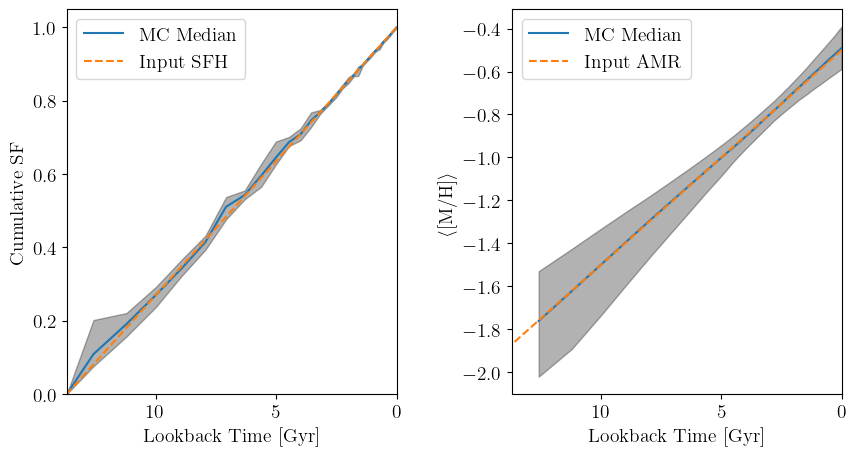

PyObject <matplotlib.legend.Legend object at 0x7f741819bbe0>

In [153]:
# Now plot cumulative SFH and MH evolution for the metallicity evolution model
fig,axs=plt.subplots(nrows=1,ncols=2,sharex=true,sharey=false,figsize=(10,5))
fig.subplots_adjust(hspace=0.0,wspace=0.35)

# axs[1].plot( vcat(exp10.(unique_template_logAge)./1e9, T_max), vcat(mdf_cum_sfr_arr,0.0), label="Result" ) # This is MAP result
# for i in axes(sys_samples, 1)[begin:min(10, end)] # This plots individual MC results
#     axs[1].plot( vcat(exp10.(unique_template_logAge)./1e9, T_max), vcat(sys_samples[i,1,:],0.0), alpha=0.5, c="orange")
# end
axs[1].plot(vcat(exp10.(unique_template_logAge)./1e9, T_max), vcat(sys_quantiles[:,2],0.0), label="MC Median")
axs[1].fill_between( vcat(exp10.(unique_template_logAge)./1e9, T_max), vcat(sys_quantiles[:,1],0.0), vcat(sys_quantiles[:,3],0.0), alpha=0.3, fc="k")
axs[1].plot( vcat(exp10.(unique_template_logAge)./1e9, T_max), vcat(cum_sfr_arr,0.0), label="Input SFH", ls="--" )
# axs[1].fill_between( vcat(exp10.(unique_template_logAge)./1e9, T_max), vcat(mdf_cum_lower,0.0), vcat(mdf_cum_upper,0.0), alpha=0.3, fc="k")

axs[1].set_xlim([T_max,0.0])
axs[1].set_ylim([0.0,1.05])
axs[1].set_xlabel("Lookback Time [Gyr]")
axs[1].set_ylabel("Cumulative SF")
axs[1].legend()

# axs[2].plot( vcat( exp10.(unique_template_logAge)./1e9, T_max), vcat(mdf_mh_med, mdf_result.map.μ[end-1]), label="Result" )
# for i in axes(sys_samples, 1)[begin:min(10, end)] # This plots individual MC results
#     # axs[2].plot( vcat(exp10.(unique_template_logAge)./1e9, T_max), vcat(sys_samples[i,3,:], sys_samples[i,3,end]), alpha=0.5, c="orange")
#     axs[2].plot( exp10.(unique_template_logAge)./1e9, sys_samples[i,3,:], alpha=0.5, c="orange")
# end
axs[2].plot( exp10.(unique_template_logAge)./1e9, sys_mh_quantiles[:,2], alpha=1, label="MC Median")
axs[2].fill_between( exp10.(unique_template_logAge)./1e9, sys_mh_quantiles[:,1], sys_mh_quantiles[:,3], alpha=0.3, fc="k")
# axs[2].fill_between( vcat(exp10.(unique_template_logAge)./1e9, T_max), vcat(mdf_mh_lower, mdf_result.map.μ[end-1]), vcat(mdf_mh_upper, mdf_result.map.μ[end-1]), alpha=0.3, fc="k")
axs[2].plot( vcat(exp10.(unique_template_logAge)./1e9, T_max), vcat(mean_mh_arr, β), label="Input AMR", ls="--" )

# axs[2].set_xlim([max_logAge, axs[2].get_xlim()[2]])
axs[2].set_xlabel("Lookback Time [Gyr]")
axs[2].set_ylabel(L"$\langle$[M/H]$\rangle$")
axs[2].legend()
# plt.savefig("example_cumsfh_systematics.pdf", bbox_inches="tight")

In [71]:
# Reset workers; this is a hack for what looks like a memory leak
# rmprocs(workers()...)

### Normalizing Templates to SFR

It can sometimes be convenient to normalize the templates to uniform SFR, rather than uniform stellar mass per template. Below we illustrate this gives the same SFH result as above, where we used templates normalized to uniform stellar mass per template.

In [73]:
# Compute change in time [yr] between bins of logAge
template_δt = diff(vcat(exp10.(unique_template_logAge), T_max * 1e9)) # exp10(max_logAge)))
sfr_norm = 1e-3 # Star formation rate in solar masses / yr to normalize templates to
# Now normalize the templates:
# SFR = stellar mass / dt; sfr_norm = A * template_norm / dt; where A is a multiplicative constant
# since we originally normalized all the templates to contain stellar mass = `template_norm`
# Solve for A = sfr_norm * dt / template_norm
sfr_templates = deepcopy(templates)
for i in eachindex(sfr_templates)
    idx = findfirst(==(template_logAge[i]), unique_template_logAge)
    A = sfr_norm * template_δt[idx] / template_norm
    sfr_templates[i] .*= A
end 

In [74]:
mdf_sfr_result = fit_sfh(LinearAMR(mdf_α, mdf_β, T_max),
                         GaussianDispersion(0.2),
                         sfr_templates,
                         data,
                         template_logAge, template_MH;
                         x0=fill(1,length(unique_template_logAge)))

StarFormationHistories.CompositeBFGSResult{StarFormationHistories.BFGSResult{Vector{Float64}, Vector{Float64}, PDMats.PDMat{Float64, Matrix{Float64}}, Optim.MultivariateOptimizationResults{Optim.BFGS{LineSearches.InitialStatic{Float64}, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}, Nothing, Nothing, Optim.Flat}, Vector{Float64}, Float64, Float64, Vector{Optim.OptimizationState{Float64, Optim.BFGS{LineSearches.InitialStatic{Float64}, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}, Nothing, Nothing, Optim.Flat}}}, Bool, @NamedTuple{f_limit_reached::Bool, g_limit_reached::Bool, h_limit_reached::Bool, time_limit::Bool, callback::Bool, f_increased::Bool}}, LinearAMR{Float64}, GaussianDispersion{Float64}}, StarFormationHistories.BFGSResult{Vector{Float64}, Vector{Float64}, LinearAlgebra.Hermitian{Float64, Matrix{Float64}}, Optim.MultivariateOptimizationResults{Optim.BFGS{LineSearches.InitialStatic{Float64}, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}, Nothing, Nothi

In [75]:
mdf_sfr_sample = rand(mdf_sfr_result.map, 10000)
@views mdf_sfr_sample[begin:end-3,:] *= sfr_norm # Correct the SFR coefficients for the template normalization

71×10000 Matrix{Float64}:
 0.00994213   0.00828003   0.0018737    …  0.00671931   0.00752873
 0.000303725  0.00203215   0.00627689      0.00101142   0.00061142
 0.00931286   0.000606987  0.00192891      0.00302538   0.0029088
 0.00103286   0.00154624   0.00194906      0.00141109   0.000367741
 0.00215436   0.00202194   0.00534193      0.00122134   0.000962152
 0.000790138  0.0147861    0.00320347   …  0.000485645  0.00322632
 0.00581511   0.00106585   0.00265586      0.00207506   0.000786997
 0.000638616  0.00155904   0.000914119     0.000868078  0.00246849
 0.00159201   0.00189683   0.00959484      0.00595235   0.000312999
 0.00261004   0.00192042   0.000887527     0.000693042  0.0130447
 0.000268943  0.00124094   0.000517893  …  0.00176515   0.00178163
 0.00029769   0.000257781  0.000705224     0.00325438   0.00212995
 0.000469178  0.000795544  0.000166066     0.000580718  0.000257101
 ⋮                                      ⋱               
 0.000479874  0.000504521  0.000581791     

In [76]:
# Now calculate quantiles
mdf_sfr_norm_lower = quantile.(eachrow(@view mdf_sfr_sample[begin:end-3,:]), 0.16)
mdf_sfr_norm_med = median.(eachrow(@view mdf_sfr_sample[begin:end-3,:]))
mdf_sfr_norm_upper = quantile.(eachrow(@view mdf_sfr_sample[begin:end-3,:]), 0.84);

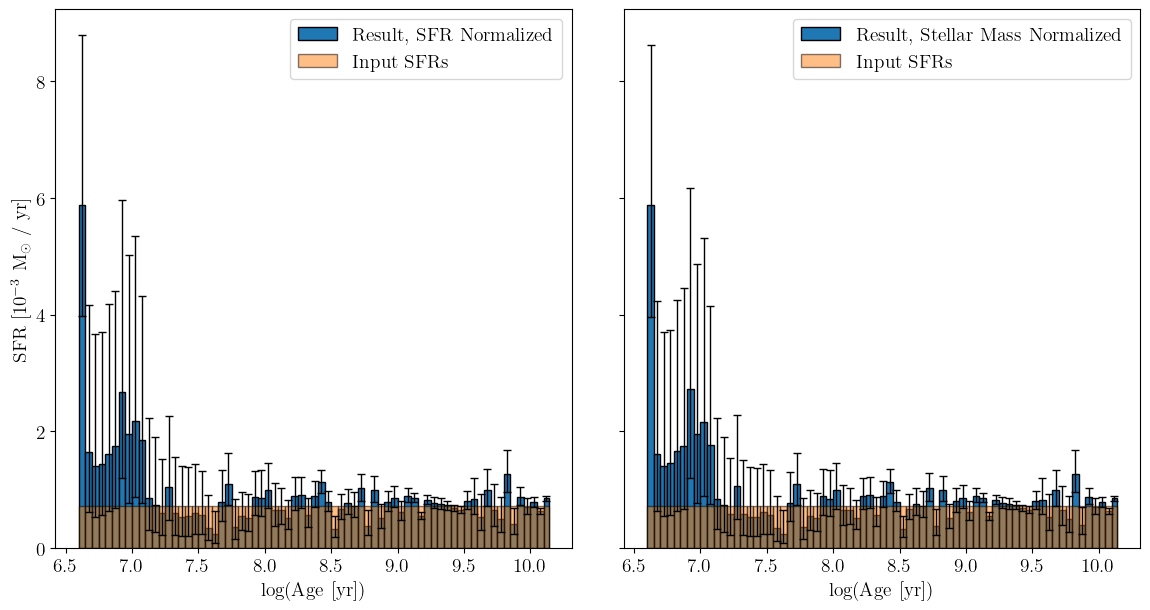

PyObject Text(0.5, 29.371800193718016, 'log(Age [yr])')

In [77]:
fig,axs = plt.subplots(nrows=1,ncols=2,sharex=true,sharey=true,figsize=(14,7))
fig.subplots_adjust(hspace=0.0,wspace=0.1)

axs[1].bar(unique_template_logAge, mdf_sfr_norm_med .* 1e3; width=diff(vcat(unique_template_logAge,max_logAge)), align="edge", 
# axs[1].bar(unique_template_logAge, mdf_sfr_result.map.μ[begin:end-3] .* 1e3 .* sfr_norm; width=diff(vcat(unique_template_logAge,max_logAge)), align="edge", 
# axs[1].bar(unique_template_logAge, mdf_sfr_result.mle.μ[begin:end-3] .* 1e3 .* sfr_norm; width=diff(vcat(unique_template_logAge,max_logAge)), align="edge", 
    yerr = [(mdf_sfr_norm_med .- mdf_sfr_norm_lower) .* 1e3, 
        (mdf_sfr_norm_upper .- mdf_sfr_norm_med) .* 1e3], 
    capsize=3, error_kw=Dict("elinewidth"=>1,"capthick"=>1), label="Result, SFR Normalized")
axs[1].bar(unique_template_logAge, sfr_arr .* 1e3; width=diff(vcat(unique_template_logAge,max_logAge)), align="edge", label="Input SFRs", alpha=0.5)

axs[1].set_xlabel("log(Age [yr])")
axs[1].set_ylabel(L"SFR [$10^{-3}$ M$_\odot$ / yr]")
axs[1].set_ylim([0.0, axs[1].get_ylim()[2]])
axs[1].legend()

axs[2].bar(unique_template_logAge, mdf_sfr_med .* 1e3; width=diff(vcat(unique_template_logAge,max_logAge)), align="edge", 
    yerr = [(mdf_sfr_med .- mdf_sfr_lower) .* 1e3, 
            (mdf_sfr_upper .- mdf_sfr_med) .* 1e3], 
    capsize=3, error_kw=Dict("elinewidth"=>1,"capthick"=>1), label="Result, Stellar Mass Normalized")
axs[2].bar(unique_template_logAge, sfr_arr .* 1e3; width=diff(vcat(unique_template_logAge,max_logAge)), align="edge", label="Input SFRs", alpha=0.5)
axs[2].legend()
axs[2].set_xlabel("log(Age [yr])")

## SFH Fitting: Unconstrained Fitting

We will now explore the methods offered to fit SFHs without constraints on the metallicity evolution. These methods are most useful when dealing with simpler stellar populations (e.g., globular clusters / ultra-faint dwarf galaxies).

### Simple Optimization

Again, the best way to fit this SFH would be to use `fit_sfh` with the correct `LinearAMR` and `GaussianDispersion` models as above, such that we are fitting the same type of hierarchical model as we used to generate the SFH. For example purposes we will show how to use some of the simpler fitting methods that fit per-template stellar masses here. These methods are generally most useful when you have a smaller set of templates that you want to use to fit the SFH. For this purpose, we will create a smaller grid of templates centered around the real age-metallicity relation; we will accept any isochrone within ± 0.2 dex of this metallicity evolution guess.

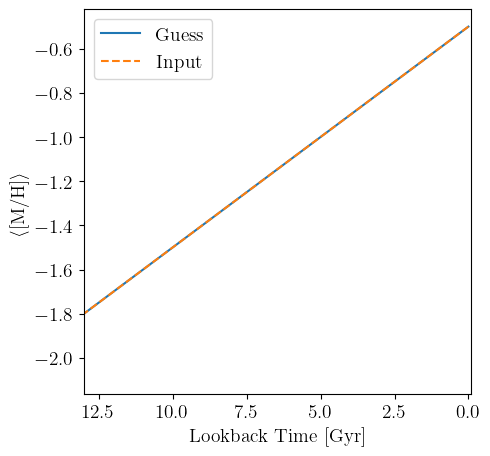

PyObject <matplotlib.legend.Legend object at 0x7f9d9f951ff0>

In [68]:
# new_α, new_β, new_σ = 0.15, -2.25, 0.2 # -0.15, -0.2, 0.2
new_α, new_β, new_σ = α, β, σ
met_func(logAge) = (T_max - exp10(logAge)/1e9) * new_α + new_β
met_func_true(logAge) = (T_max - exp10(logAge)/1e9) * α + β
laxplot = 6.6:0.01:10.2
fig,ax1=plt.subplots()
ax1.plot(exp10.(laxplot)./1e9, met_func.(laxplot),label="Guess",zorder=0)
ax1.plot(exp10.(laxplot)./1e9, met_func_true.(laxplot),label="Input",ls="--",zorder=1)
ax1.set_xlim([13.0,-0.1])
ax1.set_xlabel("Lookback Time [Gyr]")
ax1.set_ylabel(L"$\langle$[M/H]$\rangle$")
ax1.legend(loc="upper left")

Now create the limited template set.

In [69]:
# Single-threaded with push!, easier with this example
free_templates = Vector{Matrix{Float64}}(undef,0)
free_template_logAge = Vector{Float64}(undef,0)
free_template_MH = Vector{Float64}(undef,0)
for logage in unique_logAge
    mean_met = met_func(logage)
    for mh in unique_MH
        # If the current mh is more than `new_σ` dex away from mean, skip template
        abs(mh - mean_met) > new_σ && continue
        local good = findall( (table.MH .== mh) .& (table.logAge .== logage) )
        # Chop off the last star because its the 30 mag weird thing that parsec does.
        local m_ini = table.Mini[good][begin:end-1]
        local iso_mags = [table.F090W[good][begin:end-1], table.F150W[good][begin:end-1]]
        push!(free_templates, partial_cmd_smooth( m_ini, iso_mags, [F090W_error, F150W_error], 2, [1,2], imf, [F090W_complete, F150W_complete]; 
                dmod=distmod, normalize_value=template_norm, edges=edges).weights )
        push!(free_template_logAge, logage)
        push!(free_template_MH, mh)
    end
end

In [70]:
# `templates` has 1846 entries, free_templates has ~10% of that.
length(free_templates)

142

Let's start off by just obtaining the maximum likelihood estimate (MLE) via `fit_templates_lbfgsb`. We'll construct the initial guess vector `x0` with `construct_x0`.

In [71]:
import StarFormationHistories: fit_templates_lbfgsb, construct_x0
lbfgsb_result = fit_templates_lbfgsb(free_templates, data; x0=construct_x0(free_template_logAge, T_max; normalize_value=template_norm))

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          142     M =           10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  142   4850   4976   5355     0    43   9.263D-06   1.738D+03

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            

 Total User time 1.978E+00 seconds.



(1737.561767858499, [0.0, 6.3092243392336025, 0.3774299718970162, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 392.5961395092347, 1172.9423464017354, 139.94575680533316, 648.3585828080876, 300.2553224886903, 372.28817543771146, 514.5852180676904, 465.4206345967334, 325.870356070181])

In [72]:
# Calculate the cumulative SFH, SFRs, <[M/H]>(logAge) from the above result
free_coeffs = lbfgsb_result[2] .* template_norm
unique_free_template_logAge, free_cum_sfr_arr, free_sfr_arr, free_mean_mh_arr = calculate_cum_sfr(free_coeffs, free_template_logAge, free_template_MH, T_max)

([6.6, 6.65, 6.7, 6.75, 6.8, 6.85, 6.9, 6.95, 7.0, 7.05  …  9.65001, 9.70001, 9.75001, 9.80001, 9.85001, 9.90001, 9.95001, 10.00001, 10.05001, 10.10001], [1.0, 0.999373967714971, 0.9993365172559225, 0.9993365172559225, 0.9993365172559225, 0.9993365172559225, 0.9990821204493999, 0.9990821204493999, 0.9990821204493999, 0.9986779855091602  …  0.645604860384021, 0.645604860384021, 0.6161085840251482, 0.5212806946260483, 0.5017263175071199, 0.4298684064067988, 0.39091308557882415, 0.26064186758978575, 0.16651572801819506, 0.07851578583591874], [0.012988244361669194, 0.0006924857893413836, 0.0, 0.0, 0.0, 0.002968010106175201, 0.0, 0.0, 0.0033379522516951317, 0.00013650350443439693  …  0.0, 0.0004860835386089413, 0.0013927712861641693, 0.0002559691974138455, 0.0008383363709931671, 0.00040505174323767916, 0.0012072360447614766, 0.0007774168820056895, 0.0006477778697086845, 0.0007125820296876785], [-0.5000166309399301, -0.6000162328319801, -0.6000162328319801, -0.6000162328319801, -0.6000162328

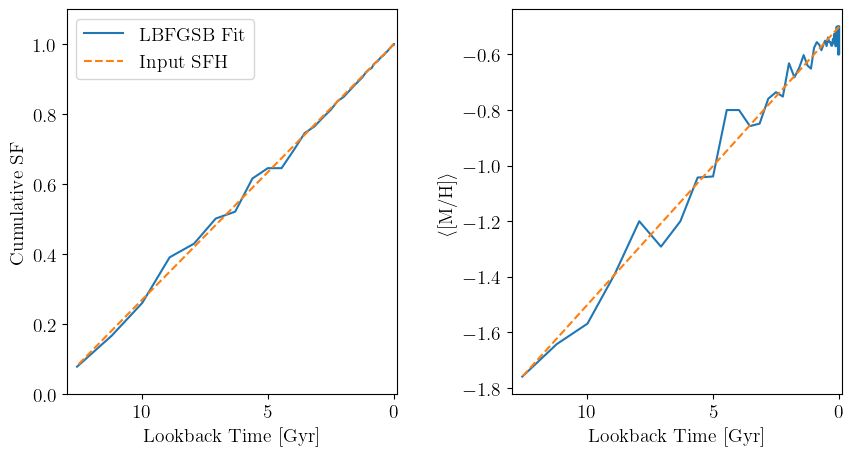

PyObject Text(457.3650849792141, 0.5, '$\\langle$[M/H]$\\rangle$')

In [73]:
fig,axs=plt.subplots(nrows=1,ncols=2,sharex=true,sharey=false,figsize=(10,5))
fig.subplots_adjust(hspace=0.0,wspace=0.35)

axs[1].plot( exp10.(unique_free_template_logAge)./1e9, free_cum_sfr_arr, label="LBFGSB Fit" )
axs[1].plot( exp10.(unique_template_logAge)./1e9, cum_sfr_arr, label="Input SFH", ls="--" )

axs[1].set_xlim([13.0,-0.1])
axs[1].set_ylim([0.0,1.1])
axs[1].set_xlabel("Lookback Time [Gyr]")
axs[1].set_ylabel("Cumulative SF")
axs[1].legend()

axs[2].plot( exp10.(unique_free_template_logAge)./1e9, free_mean_mh_arr, label="LBFGSB Fit" )
axs[2].plot( exp10.(unique_template_logAge)./1e9, mean_mh_arr, label="Input SFH", ls="--" )
axs[2].set_xlabel("Lookback Time [Gyr]")
axs[2].set_ylabel(L"$\langle$[M/H]$\rangle$")

We can also use `fit_templates`, which uses BFGS to build a dense estimate of the inverse Hessian. This function is slower than `fit_templates_lbfgsb` above, but allows for estimation of random uncertainties.

In [74]:
import StarFormationHistories: fit_templates
bfgs_result = fit_templates(free_templates, data; x0=construct_x0(free_template_logAge, T_max; normalize_value=template_norm))

(map = StarFormationHistories.LogTransformFTResult{Vector{Float64}, Vector{Float64}, Matrix{Float64}, Optim.MultivariateOptimizationResults{Optim.BFGS{LineSearches.InitialStatic{Float64}, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}, Nothing, Nothing, Optim.Flat}, Vector{Float64}, Float64, Float64, Vector{Optim.OptimizationState{Float64, Optim.BFGS{LineSearches.InitialStatic{Float64}, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}, Nothing, Nothing, Optim.Flat}}}, Bool, @NamedTuple{f_limit_reached::Bool, g_limit_reached::Bool, h_limit_reached::Bool, time_limit::Bool, callback::Bool, f_increased::Bool}}}([0.6711597287808827, 2.786979899683696, 0.6617579206662607, 0.8963766468970037, 0.49741326176615464, 0.6892953485437623, 0.4681920517844792, 0.5467529941473369, 0.5016994229652576, 0.49781429244012415  …  139.9339354464, 203.88157215510986, 1077.1169421323534, 239.99636639376698, 632.9659868671882, 333.8928576448296, 374.43089134518607, 516.1480680692041, 465.77713539982

`bfgs_result.mle` contains information for the maximum likelihood estimate; this is most similar to what is returned by `fit_templates_lbfgsb` but not exactly equal due to differences in the internal convergence criteria of the fitting methods.

In [75]:
bfgs_result.mle.μ .- lbfgsb_result[2]

142-element Vector{Float64}:
  2.2689104129681393e-43
  0.005227463654867037
 -0.0025828470130770387
  1.9170131225444348e-16
  1.7228712459554862e-46
  2.4194262809988427e-9
  3.2606961626166346e-54
  6.441836482749052e-36
  2.777997927216779e-38
  7.095239061504328e-51
  5.39587522916262e-41
  0.0012824543353979756
  1.1177621591696948e-63
  ⋮
  0.5487546188081751
 -1.3181811035663173
  1.7755211290463648e-11
  0.9123870937488618
  0.6341451593546026
 -1.4776289266650338
 -0.05504532952500085
  0.6985076145549556
 -0.03113547232220526
  0.08522821038457096
 -0.0975874254311293
 -0.06130785531740912

Of additional note are the uncertainty estimates, available as `bfgs_result.map.σ` and `bfgs_result.mle.σ`. These are essentially standard errors derived from the diagonal of the covariance matrix of the fitting parameters. The `bfgs_result.map` result contains the maximum a posteriori result and is often very comparable to the mode of posterior samples obtained via Hamiltonian Monte Carlo (provided by `hmc_sample`) or MCMC (provided by `mcmc_sample`). We don't generally recommend the use of `mdf_result.mle.σ` because the estimate of the covariance matrix obtained during the BFGS fit can be poorly conditioned when best-fit SFRs are 0, but we provide it for completeness.

In [76]:
bfgs_result.map.μ

142-element Vector{Float64}:
    0.6711597287808827
    2.786979899683696
    0.6617579206662607
    0.8963766468970037
    0.49741326176615464
    0.6892953485437623
    0.4681920517844792
    0.5467529941473369
    0.5016994229652576
    0.49781429244012415
    0.4975510460296729
    0.6378922134625628
    0.4594830634417243
    ⋮
  462.68268391812825
  172.96276963693958
  139.9339354464
  203.88157215510986
 1077.1169421323534
  239.99636639376698
  632.9659868671882
  333.8928576448296
  374.43089134518607
  516.1480680692041
  465.7771353998209
  328.5100565799611

In [77]:
bfgs_result.map.σ

142-element Vector{Float64}:
   0.6393845424282453
   1.1272124579304348
   0.6311136743868222
   0.8422151672507794
   0.486052783833231
   0.6653206733640258
   0.46081892665111956
   0.5347183079884412
   0.49223495790745797
   0.4905934761438525
   0.48934406308766926
   0.6204659279637948
   0.45360586719597845
   ⋮
 175.86293344457067
 128.37385116019712
 105.57212462718002
 129.27332813735748
 138.76135186373827
 142.32709266297593
  68.88387604504705
  86.57834760160917
  39.61706911928787
  44.13880761680111
  38.88437346966368
  36.823920335366324

### Sampling from Inverse Hessian

We'll now draw samples from the posterior using the same approximation techinque as we did in the previous section.

In [78]:
hessian_sample = rand(bfgs_result.map, 10000) .* template_norm
# The above is effectively doing
# hessian_dist = Distributions.MvNormal(Optim.minimizer(bfgs_result.map.result),
#                         LinearAlgebra.Hermitian(bfgs_result.map.invH))
# hessian_sample = exp.(rand(hessian_dist, 10000)) .* template_norm

# Calculate the cumulative SFH for each sample
# and find the 1-σ quantile range for both the cumulative SFH and the SFRs
hessian_cum_sfr = Vector{Vector{Float64}}(undef,0)
hessian_sfr = Vector{Vector{Float64}}(undef,0)
for x in eachcol(hessian_sample)
    _, hessian_1, hessian_2, hessian_mh = calculate_cum_sfr(x, free_template_logAge, free_template_MH, T_max)
    push!(hessian_cum_sfr, hessian_1)
    push!(hessian_sfr, hessian_2)
end
hessian_cum_sfr = reduce(hcat, hessian_cum_sfr) 
hessian_sfr = reduce(hcat, hessian_sfr) 
# Now calculate quantiles
hessian_cum_lower = quantile.(eachrow(hessian_cum_sfr), 0.16)
hessian_cum_med = median.(eachrow(hessian_cum_sfr))
hessian_cum_upper = quantile.(eachrow(hessian_cum_sfr), 0.84)
hessian_sfr_lower = quantile.(eachrow(hessian_sfr), 0.16)
hessian_sfr_med = median.(eachrow(hessian_sfr))
hessian_sfr_upper = quantile.(eachrow(hessian_sfr), 0.84)

71-element Vector{Float64}:
 0.011085321046883506
 0.006912008817724217
 0.0048872923222459995
 0.0037854707328528314
 0.0032763879831921453
 0.003309822768685931
 0.002543552364548502
 0.002523793353354795
 0.002741071311185307
 0.0022329605704923465
 0.001706048667020869
 0.001810901125758526
 0.0017060049595674222
 ⋮
 0.0011677678815833795
 0.0012725761337671066
 0.0005254404031924141
 0.0008430288658772412
 0.0014851522877531952
 0.001072563493437745
 0.0010755570277097815
 0.0006410180457440616
 0.0013869231964129256
 0.0008585908225286979
 0.0006897226882523541
 0.000755607836830087

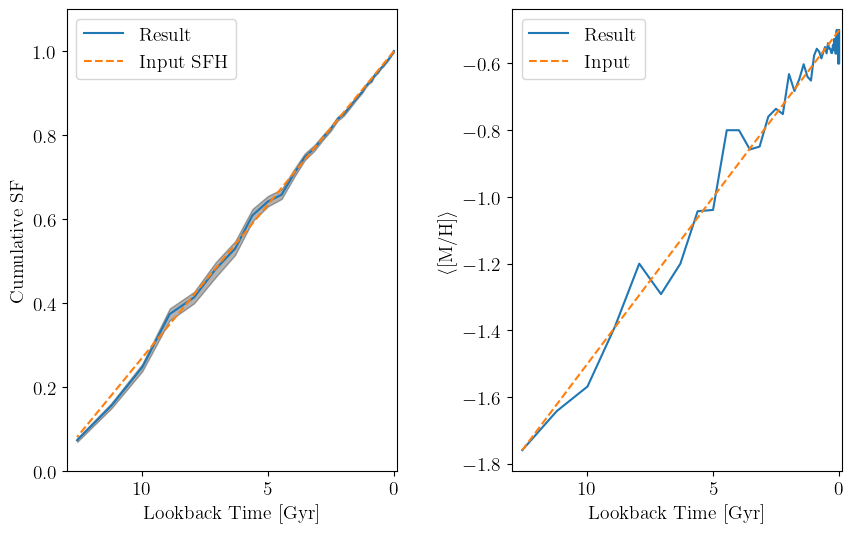

PyObject <matplotlib.legend.Legend object at 0x7f9d9fb15030>

In [79]:
# Now plot cumulative SFH and MH evolution
fig,axs=plt.subplots(nrows=1,ncols=2,sharex=true,sharey=false,figsize=(10,6))
fig.subplots_adjust(hspace=0.0,wspace=0.35)

# axs[1].plot( exp10.(unique_free_template_logAge)./1e9, cum_sfr_arr, label="Result" )
axs[1].plot( exp10.(unique_free_template_logAge)./1e9, hessian_cum_med, label="Result" )
axs[1].plot( exp10.(unique_template_logAge)./1e9, cum_sfr_arr, label="Input SFH", ls="--" )
axs[1].fill_between( exp10.(unique_free_template_logAge)./1e9, hessian_cum_lower, hessian_cum_upper, alpha=0.3, fc="k")
axs[1].set_xlim([13.0,-0.1])
axs[1].set_ylim([0.0,1.1])
axs[1].set_xlabel("Lookback Time [Gyr]")
axs[1].set_ylabel("Cumulative SF")
axs[1].legend()

axs[2].plot( exp10.(unique_free_template_logAge)./1e9, free_mean_mh_arr, label="Result" )
axs[2].plot( exp10.(unique_template_logAge)./1e9, mean_mh_arr, label="Input", ls="--" )
# axs[2].plot( exp10.(unique_template_logAge)./1e9, met_func.(unique_template_logAge), c="k", label="Guess",ls="--")
axs[2].set_xlabel("Lookback Time [Gyr]")
axs[2].set_ylabel(L"$\langle$[M/H]$\rangle$")
axs[2].legend()

We can alternatively use the `Measurements.jl` package to estimate the uncertainties on the SFRs assuming that the `bfgs_result.map.σ` are Gaussian and *uncorrelated*. In general we expect some correlation in the star formation rates between age bins (as shown above in the constrained metallicity case), but this approach can be useful for quick diagnostics. 

In [80]:
import Measurements: uncertainty, ±
hessian_sfrerr = uncertainty.(calculate_cum_sfr(bfgs_result.map.μ .± bfgs_result.map.σ,
                                                            free_template_logAge, free_template_MH, T_max; normalize_value=template_norm)[3]) .* 1e3

71-element Vector{Float64}:
 2.6678057747113195
 1.9309543383437673
 1.3473394795444993
 1.0287509021878751
 0.9026882745090267
 0.914783455031564
 0.690504892868098
 0.6889621372547996
 0.758422952321689
 0.6062329465844566
 0.4814725180469458
 0.4937245775362478
 0.478365795267449
 ⋮
 0.22239812889257207
 0.1753681001335861
 0.14463240601095143
 0.2290343872639561
 0.2998468184089493
 0.2990620992952306
 0.25205106899855917
 0.17219961421711677
 0.18277947099814565
 0.09067119885338094
 0.04332082820555777
 0.048226737789552415

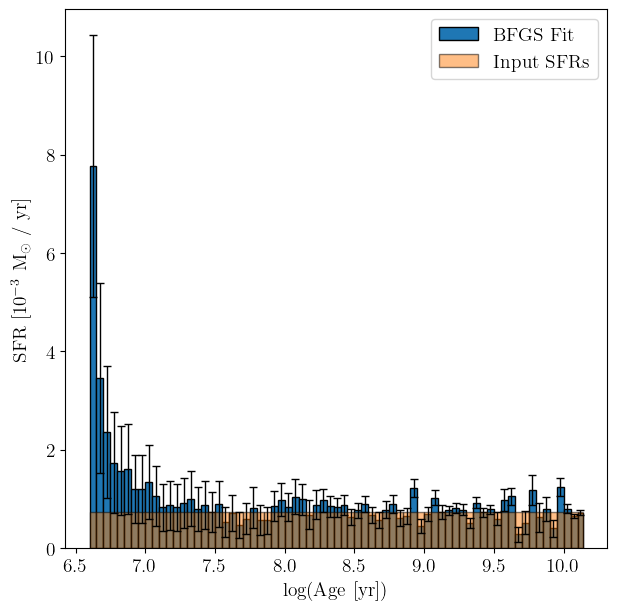

PyObject <matplotlib.legend.Legend object at 0x7f9da24b94e0>

In [81]:
fig,ax1 = plt.subplots(figsize=(7,7))
# ax1.bar(unique_free_template_logAge[begin:end-1], free_sfr_arr[begin:end-1] .* 1e3; width=diff(unique_free_template_logAge), align="edge", yerr = hessian_sfrerr[begin:end-1], capsize=3, error_kw=Dict("elinewidth"=>1,"capthick"=>1), label="LBFGS Fit")
ax1.bar(unique_free_template_logAge, hessian_sfr_med .* 1e3; width=diff(vcat(unique_template_logAge,max_logAge)), align="edge", yerr = hessian_sfrerr, capsize=3, error_kw=Dict("elinewidth"=>1,"capthick"=>1), label="BFGS Fit")
ax1.bar(unique_template_logAge, sfr_arr .* 1e3; width=diff(vcat(unique_template_logAge,max_logAge)), align="edge", label="Input SFRs", alpha=0.5)
ax1.set_xlabel("log(Age [yr])")
ax1.set_ylabel(L"SFR [$10^{-3}$ M$_\odot$ / yr]")
ax1.set_ylim([0.0, ax1.get_ylim()[2]])
ax1.legend()

Overall the performance here is not bad, but inferior to the constrained AMR fit we performed previously.

If we make the same plot with the `hessian_sfr_lower` and `hessian_sfr_upper` vectors, which utilize the samples from the full variance-covariance matrix, we see that the uncertainties look very similar across most of the plot, but are not identical due to the inclusion of covariance between parameters.

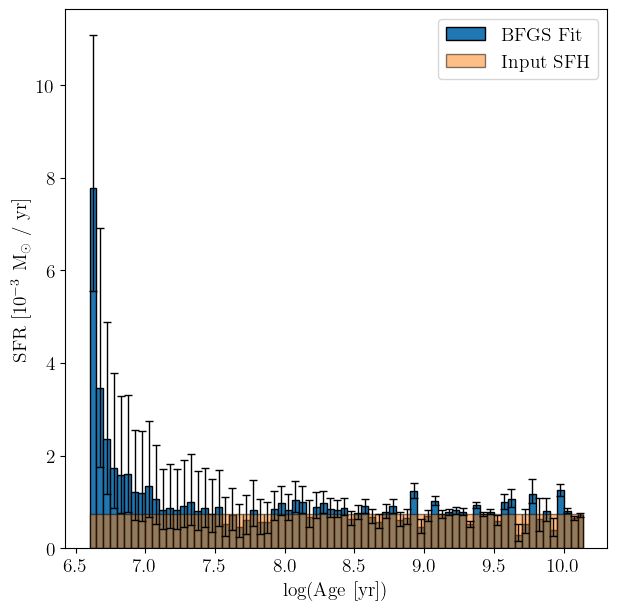

PyObject <matplotlib.legend.Legend object at 0x7f9e23e66ad0>

In [82]:
fig,ax1 = plt.subplots(figsize=(7,7))
ax1.bar(unique_free_template_logAge, hessian_sfr_med .* 1e3; width=diff(vcat(unique_template_logAge,max_logAge)), align="edge", 
    yerr = [(hessian_sfr_med .- hessian_sfr_lower) .* 1e3, 
            (hessian_sfr_upper .- hessian_sfr_med) .* 1e3], 
    capsize=3, error_kw=Dict("elinewidth"=>1,"capthick"=>1), label="BFGS Fit")
ax1.bar(unique_template_logAge, sfr_arr .* 1e3; width=diff(vcat(unique_template_logAge,max_logAge)), align="edge", label="Input SFH", alpha=0.5)
ax1.set_xlabel("log(Age [yr])")
ax1.set_ylabel(L"SFR [$10^{-3}$ M$_\odot$ / yr]")
ax1.set_ylim([0.0, ax1.get_ylim()[2]])
ax1.legend()

### Sampling via MCMC
The unconstrained fitting methods are not optimal for MCMC. Since so many of the fitting coefficients are 0, our transition acceptance probabilities are extremely low, giving us fairly poor convergence unless we run very long chains.

In [83]:
import StarFormationHistories: mcmc_sample
import Distributions: MvNormal
import LinearAlgebra: I

nwalkers = 1000
nsteps = 2000
burn_idx = 200
# Walker initial positions sampled from a multivariate normal distribution with means equal to the BFGS MLE
# and identity covariance matrix. The `max` call makes sure none of the cofficients have initial conditions less than 0. 
mcmc_x0 = [max.(0.0, rand(MvNormal(bfgs_result.mle.μ, I))) for i in 1:nwalkers]
mcmc_result = mcmc_sample(free_templates, data, mcmc_x0, nwalkers, nsteps; nthin=5); # nthin=5 to only save every 5 steps

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter ~/.julia/packages/ProgressMeter/kVZZH/src/ProgressMeter.jl:594
emcee, niter=2000000, nwalkers=1000: 100%|█████████████████████████| Time: 0:00:33
  accept_ratio_mean:      0.00872
  accept_ratio_std:       0.00423
  accept_ratio_outliers:  44
  burnin_phase:           false


Note the very low transition acceptance ratio of <1%. If we plot the trace of the chains we can see that they have not reached their stationary distribution even after 2000 steps. MCMC can work well when considering fewer templates, or when fewer of the fitting coefficients are zero. However, this application is better suited to Hamiltonian Monte Carlo. 

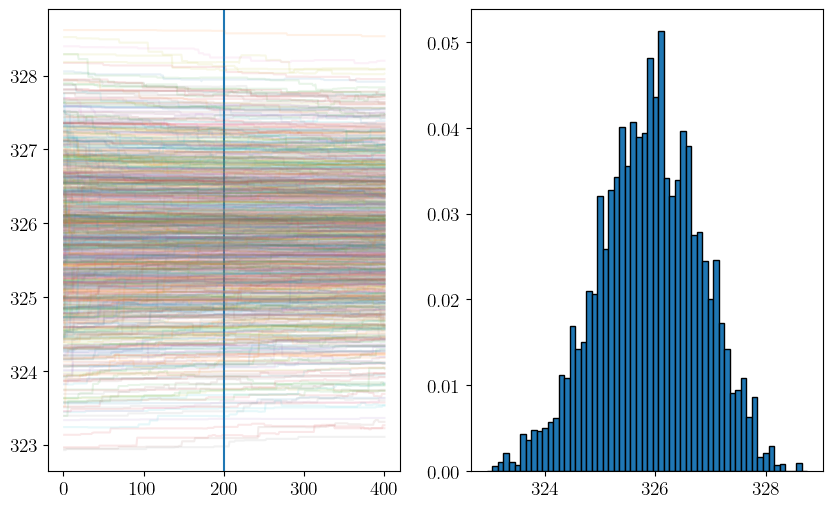

In [84]:
import StatsBase: fit, Histogram, normalize

fig, (ax0, ax1) = plt.subplots(nrows=1,ncols=2,sharex=false,sharey=false,figsize=(10,6))
fig.subplots_adjust(hspace=0.0,wspace=0.2)

ax0.axvline(burn_idx)
for i in 1:size(mcmc_result,3)
    ax0.plot(first(axes(mcmc_result)), mcmc_result[:,end,i], alpha=0.1, rasterized=true) 
end

ax1_hist = normalize(fit(Histogram, vec(mcmc_result[burn_idx:end,end,:]); nbins=100, closed=:left); mode=:probability) #:pdf, :density, :probability, :none
ax1.bar(first(ax1_hist.edges)[2:end], ax1_hist.weights, width=step(first(ax1_hist.edges)), ec="k"); # fc="k"

### Sampling via Hamiltonian Monte Carlo

Let us now compare to `hmc_sample`, which utilizes the No-U-Turn sampler variant of Hamiltonian Monte Carlo implemented in `DynamicHMC.jl` to sample from the posterior. Note that the method implementing HMC sampling for hierarchical models like the `LinearAMR` age-metallicity relation used above is `sample_sfh`. This is a more rigorous way to obtain posterior samples than using the approximation of `fit_sfh` and can be more efficient than `sample_mcmc` for high-dimensional problems or when many of the coefficients are 0. However, we will show that the approximation of `fit_sfh` still compares favorably with this more accurate method.

In [85]:
import DynamicHMC
import StarFormationHistories: hmc_sample
mc_result = hmc_sample(free_templates, data, 1000; reporter=DynamicHMC.ProgressMeterReport());

Warmup: 100%|███████████████████████████████████████████| Time: 0:00:14
Warmup: 100%|███████████████████████████████████████████| Time: 0:00:07
Warmup: 100%|███████████████████████████████████████████| Time: 0:00:11
Warmup: 100%|███████████████████████████████████████████| Time: 0:00:21
Warmup: 100%|███████████████████████████████████████████| Time: 0:00:03
MCMC: 100%|█████████████████████████████████████████████| Time: 0:00:47


We can check the summary statistics to ensure the samples have a high acceptance rate and are converging properly (turning % should be ~100%).

In [86]:
DynamicHMC.Diagnostics.summarize_tree_statistics(mc_result.tree_statistics)

Hamiltonian Monte Carlo sample of length 1000
  acceptance rate mean: 0.93, 5/25/50/75/95%: 0.75 0.92 0.97 0.99 1.0
  termination: divergence => 0%, max_depth => 0%, turning => 100%
  depth: 0 => 0%, 1 => 0%, 2 => 0%, 3 => 0%, 4 => 0%, 5 => 0%, 6 => 0%, 7 => 100%, 8 => 0%

The parameters optimized by `fit_sfh` and `hmc_sample` are actually the logarithms of the coefficients, not the coefficients themselves, so we need to transform the samples here.

In [87]:
mc_matrix = exp.(mc_result.posterior_matrix) .* template_norm

142×1000 Matrix{Float64}:
   906.517        1980.62       …      83.9435       1076.08
  2202.19          263.16            2880.92         1826.49
  1762.63          221.093            109.953         742.454
   807.531        1737.32            2656.53          122.522
   340.425        2394.54               6.87011         6.3403
  3284.71           13.1083     …    1237.29          232.002
   692.831         282.256              4.61349      1584.32
   326.478         597.984            478.352         328.388
   570.553         757.488            146.42         1043.92
   849.908          60.8856           361.791         802.277
   435.262         571.496      …     104.454          40.4165
   745.516         216.969             68.2502        245.385
   410.943         668.407             77.8323       1749.28
     ⋮                          ⋱                  
     3.56652e5  360939.0        …       4.60975e5       5.75536e5
 54155.6             2.3726e5       12536.7          

Calculate statistics from the MC samples.

In [88]:
# Calculate the cumulative SFH for each sample in the chain
# and find the 1-σ range
mc_cum_sfr = Vector{Vector{Float64}}(undef,0)
mc_sfr = Vector{Vector{Float64}}(undef,0)
for x in eachcol(mc_matrix)
    _, mc_1, mc_2, mc_mh = calculate_cum_sfr(x, free_template_logAge, free_template_MH, T_max)
    push!(mc_cum_sfr, mc_1)
    push!(mc_sfr, mc_2)
end
mc_cum_sfr = reduce(hcat, mc_cum_sfr) # hcat( mc_cum_sfr... )
mc_sfr = reduce(hcat, mc_sfr) # hcat( mc_sfr... )
# Calculate quantiles
mc_cum_lower = quantile.(eachrow(mc_cum_sfr), 0.16)
mc_cum_med = median.(eachrow(mc_cum_sfr))
mc_cum_upper = quantile.(eachrow(mc_cum_sfr), 0.84)
mc_sfr_lower = quantile.(eachrow(mc_sfr), 0.16)
mc_sfr_med = median.(eachrow(mc_sfr))
mc_sfr_upper = quantile.(eachrow(mc_sfr), 0.84)

71-element Vector{Float64}:
 0.00922978899941167
 0.004978484769494773
 0.0033437965297403735
 0.0024190695981763225
 0.00206856768732298
 0.002168597926422008
 0.0016077193922358784
 0.0016490326729730357
 0.0017536782563899087
 0.0013729281884987813
 0.0011435111915239985
 0.0011630936630793879
 0.001183042114353714
 ⋮
 0.0011064295254224
 0.0012316348039259147
 0.0003686859327781162
 0.0006490005604719685
 0.0013668718329182946
 0.0009411814630244037
 0.0009207369240032512
 0.0005004194403417012
 0.0013375600793267242
 0.0008388282737178627
 0.0006879989025269941
 0.0007555415152565343

And we'll plot the cumulative SFHs:

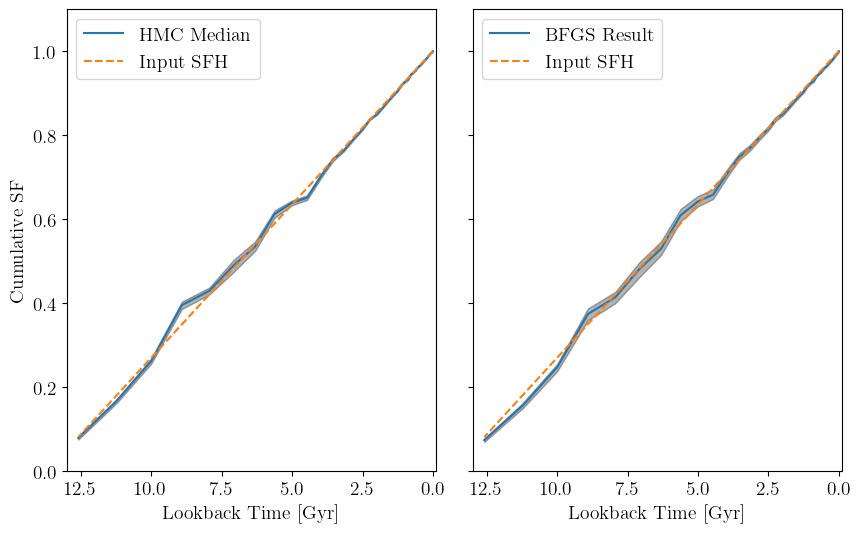

PyObject <matplotlib.legend.Legend object at 0x7f9da17d20b0>

In [89]:
fig,axs=plt.subplots(nrows=1,ncols=2,sharex=true,sharey=true,figsize=(10,6))
fig.subplots_adjust(hspace=0.0,wspace=0.1)

axs[1].plot( exp10.(unique_free_template_logAge)./1e9, mc_cum_med, label="HMC Median" )
axs[1].plot( exp10.(unique_template_logAge)./1e9, cum_sfr_arr, label="Input SFH", ls="--" )
axs[1].fill_between( exp10.(unique_free_template_logAge)./1e9, mc_cum_lower, mc_cum_upper, alpha=0.3, fc="k") 

axs[1].set_xlim([13.0,-0.1])
axs[1].set_ylim([0.0,1.1])
axs[1].set_xlabel("Lookback Time [Gyr]")
axs[1].set_ylabel("Cumulative SF")
axs[1].legend()

axs[2].plot( exp10.(unique_free_template_logAge)./1e9, hessian_cum_med, label="BFGS Result" )
axs[2].plot( exp10.(unique_template_logAge)./1e9, cum_sfr_arr, label="Input SFH", ls="--" )
axs[2].fill_between( exp10.(unique_free_template_logAge)./1e9, hessian_cum_lower, hessian_cum_upper, alpha=0.3, fc="k") 
axs[2].set_xlabel("Lookback Time [Gyr]")
axs[2].legend()

The differences are more obvious in the SFRs,

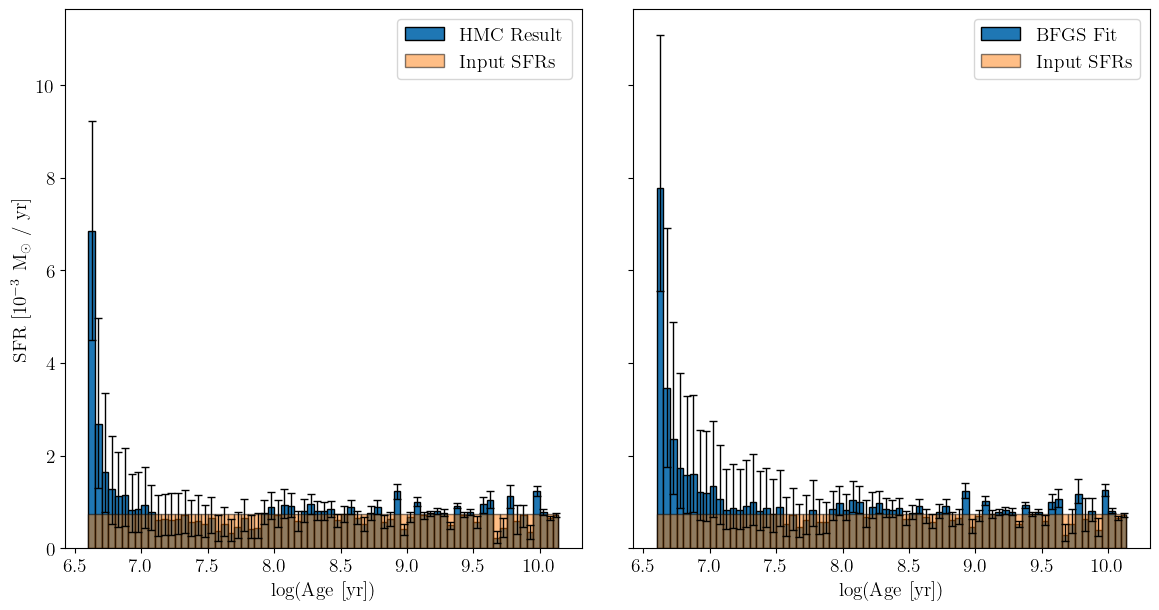

PyObject Text(0.5, 29.371800193718016, 'log(Age [yr])')

In [90]:
fig,axs = plt.subplots(nrows=1,ncols=2,sharex=true,sharey=true,figsize=(14,7))
fig.subplots_adjust(hspace=0.0,wspace=0.1)

axs[1].bar(unique_free_template_logAge, mc_sfr_med .* 1e3; width=diff(vcat(unique_template_logAge,max_logAge)), align="edge", 
    yerr = [(mc_sfr_med .- mc_sfr_lower) .* 1e3, 
        (mc_sfr_upper .- mc_sfr_med) .* 1e3], 
    capsize=3, error_kw=Dict("elinewidth"=>1,"capthick"=>1), label="HMC Result")
axs[1].bar(unique_template_logAge, sfr_arr .* 1e3; width=diff(vcat(unique_template_logAge,max_logAge)), align="edge", label="Input SFRs", alpha=0.5)

axs[1].set_xlabel("log(Age [yr])")
axs[1].set_ylabel(L"SFR [$10^{-3}$ M$_\odot$ / yr]")
axs[1].legend()

axs[2].bar(unique_free_template_logAge, hessian_sfr_med .* 1e3; width=diff(vcat(unique_template_logAge,max_logAge)), align="edge", 
    yerr = [(hessian_sfr_med .- hessian_sfr_lower) .* 1e3, 
            (hessian_sfr_upper .- hessian_sfr_med) .* 1e3], 
    capsize=3, error_kw=Dict("elinewidth"=>1,"capthick"=>1), label="BFGS Fit")
axs[2].bar(unique_template_logAge, sfr_arr .* 1e3; width=diff(vcat(unique_template_logAge,max_logAge)), align="edge", label="Input SFRs", alpha=0.5)
axs[2].legend()
axs[2].set_xlabel("log(Age [yr])")

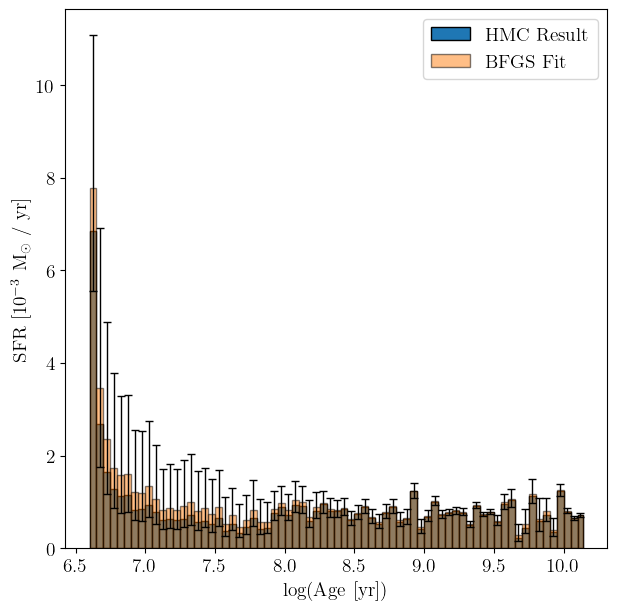

PyObject <matplotlib.legend.Legend object at 0x7f9da0fb19c0>

In [91]:
# _, _, tmp_sfr, _ = calculate_cum_sfr(bfgs_result.map.μ .* template_norm, free_template_logAge, free_template_MH)

fig,ax1 = plt.subplots(figsize=(7,7))

ax1.bar(unique_free_template_logAge, mc_sfr_med .* 1e3; width=diff(vcat(unique_template_logAge,max_logAge)), align="edge", label="HMC Result")
# ax1.bar(unique_free_template_logAge, hessian_sfr_med .* 1e3; width=diff(vcat(unique_template_logAge,max_logAge)), align="edge", label="BFGS Fit", alpha=0.5) 
ax1.bar(unique_free_template_logAge, hessian_sfr_med .* 1e3; width=diff(vcat(unique_template_logAge,max_logAge)), align="edge", 
        yerr = [(hessian_sfr_med .- hessian_sfr_lower) .* 1e3, 
                (hessian_sfr_upper .- hessian_sfr_med) .* 1e3], 
        capsize=3, error_kw=Dict("elinewidth"=>1,"capthick"=>1), label="BFGS Fit", alpha=0.5)
# ax1.bar(unique_free_template_logAge, tmp_sfr .* 1e3; width=diff(vcat(unique_template_logAge,max_logAge)), align="edge", label="BFGS Fit", alpha=0.5) 

ax1.set_xlabel("log(Age [yr])")
ax1.set_ylabel(L"SFR [$10^{-3}$ M$_\odot$ / yr]")
ax1.set_ylim([0.0, ax1.get_ylim()[2]])
ax1.legend()

Thus the approximations we made above when deriving the uncertainties from the BFGS results that 
1. the posterior is well-approximated by a multivariate Gaussian in the fitting variables `θ = log(coeffs)` in the vicinity of the maximum a posteriori and 
2. the inverse Hessian approximation produced by the BFGS optimization is a good estimate of the variance-covariance matrix of said Gaussian

are not fully correct, but they are good enough in most cases that they can produce very similar posterior samples to the full HMC analysis at a fraction of the computational cost (a few seconds compared to minutes or hours).

In [92]:
GC.gc() # Explicit garbage collection when finished